In [24]:
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [25]:
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings('ignore')

# RQ1. Feature Analysis

In [26]:
feature_datadir = "feature_data"

### 2.1 Spearman Correlation Analysis between Features

In [27]:
def compute_speamanr_corr_btwn_features_p_and_coef_tjit(datafile):
    """
    """
    from sklearn.preprocessing import MinMaxScaler
    with open(datafile) as f:
        ccms = json.load(f)
   
    metric_names = [' Lines Added ','Lines Deleted','  Directory  ','    File      ','  Subsystem  ', '   Entropy   ',
                    '   Changes   ', ' Developers ', '     Age     ', 
                    ' Piror Chgs ', ' Recent Chgs ', ' Subsys Chgs ', '  Awareness  ', 
                    '$sim2r_{sum}$', '$sim2r_{max}$', '$sim2r_{mean}$',
                    '     $\mathbf{CT_{all}}$       ', '    $\mathbf{CT_{u}}$    ', '    $\mathbf{ET_{u}}$    ', '    $\mathbf{VT_{u}}$    ',
                    '    $\mathbf{CT_{m}}$    ', '    $\mathbf{ET_{m}}$    ', '    $\mathbf{VT_{m}}$    ']
    
    feature_arr = np.asarray(ccms['features'])
    new_feature_arr = np.zeros(feature_arr.shape)
    # new_feature_arr = np.delete(new_feature_arr, [-1, -2, -3], axis=1)
    new_feature_arr[:,:4] = feature_arr[:,:4]
    new_feature_arr[:,4] = feature_arr[:,5] # to match with metric_names
    new_feature_arr[:,5] = feature_arr[:,4]
    new_feature_arr[:,6:16] = feature_arr[:,6:16]
    new_feature_arr[:,16] = feature_arr[:,19]
    new_feature_arr[:,17] = feature_arr[:,16]
    new_feature_arr[:,18] = feature_arr[:,17]
    new_feature_arr[:,19] = feature_arr[:,18]
    new_feature_arr[:,20] = feature_arr[:,20]
    new_feature_arr[:,21] = feature_arr[:,21]
    new_feature_arr[:,22] = feature_arr[:,22]
    
    # scale
    scaler = MinMaxScaler()
    new_feature_arr = 100 * scaler.fit_transform(new_feature_arr)
    
    from scipy.stats import spearmanr
        
    coeff_arr, pval_arr = spearmanr(new_feature_arr)
    
    
    coeff_df = pd.DataFrame(data = coeff_arr, index = metric_names, columns = metric_names)
    pval_df = pd.DataFrame(data = pval_arr, index = metric_names, columns = metric_names)
    
    return coeff_df, pval_df, metric_names

In [28]:
def plot_heatmap(project, max_days, corrs, pvals, figsize = (10, 10), figname = None):
    """
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    
    mask = pvals.values <= 0.00000005 
    sns.heatmap(corrs * (pvals <= 0.05), mask = np.triu(corrs, k = 1), center = 0,
                annot = True, cmap='coolwarm', #cmap = plt.cm.Reds, 
                ax = ax, annot_kws={"size": 14}, fmt=".2f")
    
    cbar = ax.collections[0].colorbar

    cbar.ax.tick_params(labelsize=20)
    
    ax.tick_params(labelsize = 20)
    ax.tick_params(labelsize = 20, axis = 'x', labelrotation = 80)
    tick_colors = ['k'] * 16 + ['red'] * 8
    for xticklabel, yticklabel, tick_color in zip(ax.get_xticklabels(), ax.get_yticklabels(), tick_colors):
        xticklabel.set_color(tick_color)
        yticklabel.set_color(tick_color)
    
    fig.tight_layout()
    if figname is not None:
        fig.savefig(figname)
        
    plt.show()


=============================== Lang ===============================


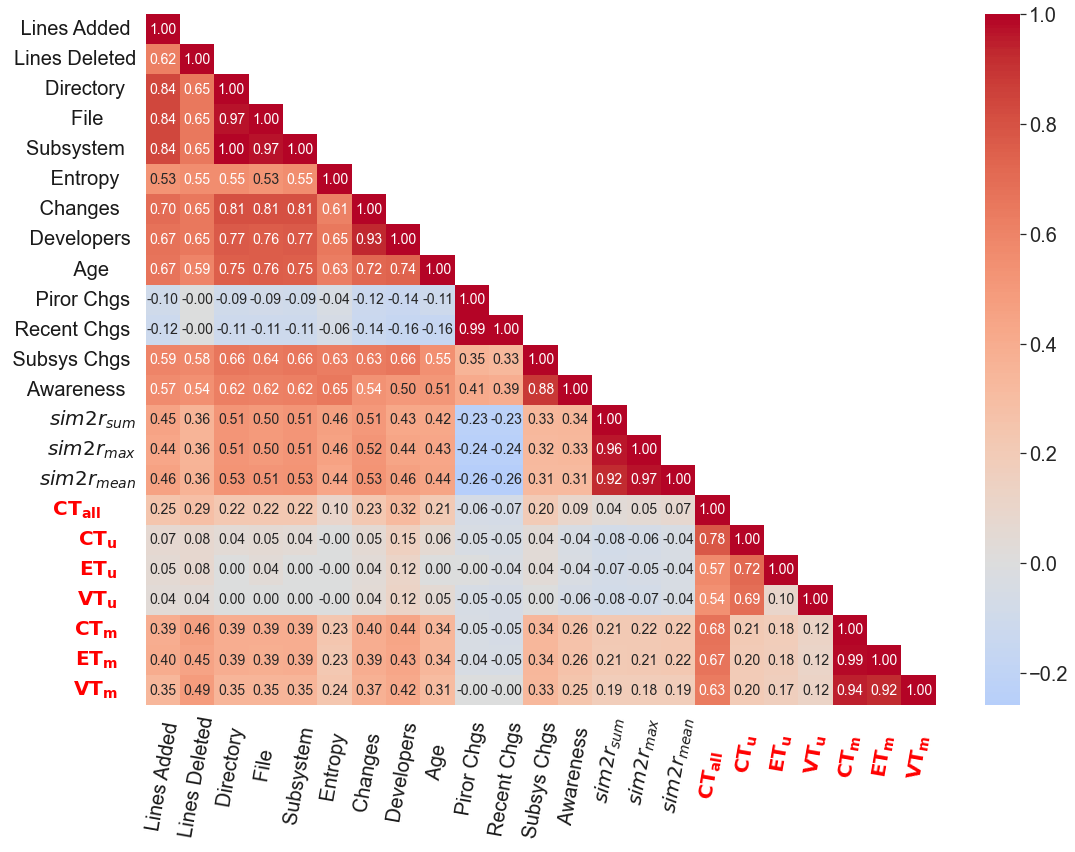

=============================== Math ===============================


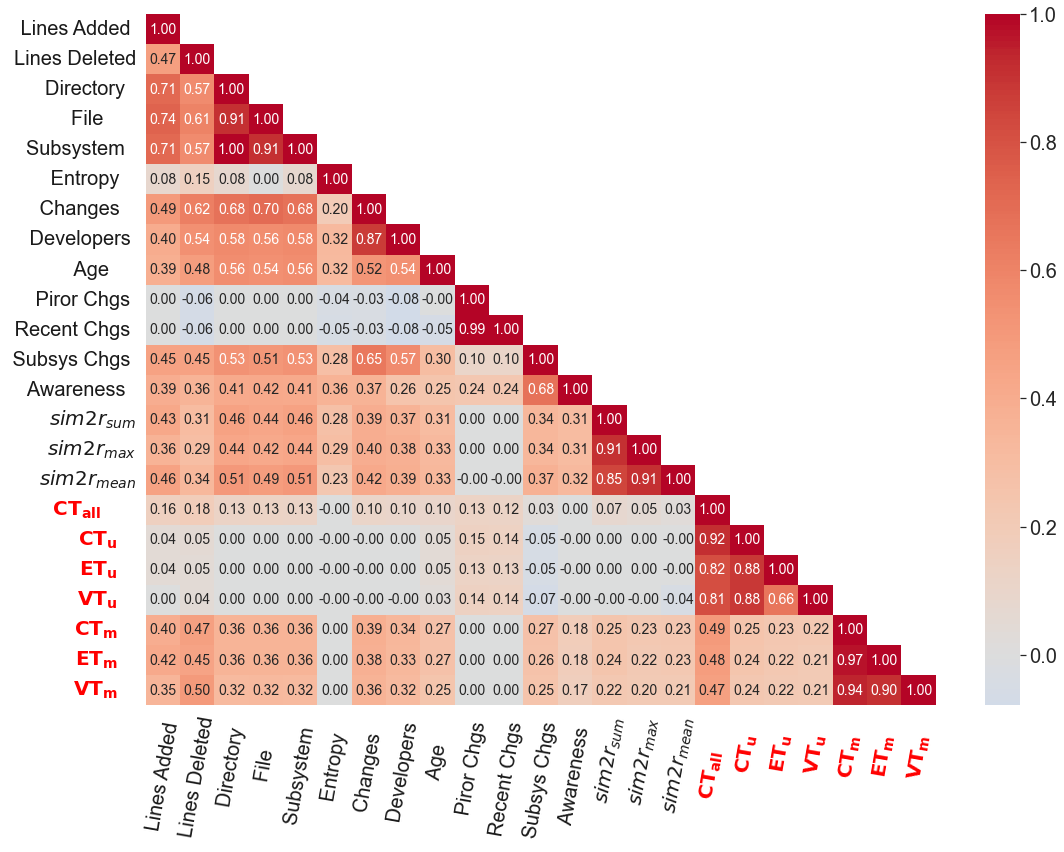

In [29]:
# spearman correlation analysis between features (for each project and time-window pair)
for project in ['Lang', 'Math']:
    print("=============================== {} ===============================".format(project))
    datafile = os.path.join(feature_datadir+'/with-tjit', "{}.ccms.tjit_diff.json".format(project))
    # compute corr & plot
    corr_arr, pval_arr, metric_names = compute_speamanr_corr_btwn_features_p_and_coef_tjit(datafile)
    plot_heatmap(project, 30, corr_arr, pval_arr, figsize = (16, 12), figname=f'img/{project}HeatMapColorAll.pdf')

## 2. Mannwhinteny U-test on similartiy features of fix-inducing and non-inducing commits

In [30]:
def analy_by_u_test_on_features(datafile, target_commits_1, target_commits_2, 
                                metric_name, alternative = 'greater'):
    """
    check whether a randomly selected value in target_commits_1 
    is greater/less than a randomly selected value in target_commits_2
    """
    from scipy.stats import mannwhitneyu

    with open(datafile) as f:
        ccms = json.load(f)
    
    metric_names = ccms['headers'][1:]
    idx_to_target_metric = metric_names.index(metric_name)
    
    commits = [commit for commit,label in ccms['commits_and_labels']]
    
    indices_to_commits_1 = sorted([commits.index(c) for c in target_commits_1])
    indices_to_commits_2 = sorted([commits.index(c) for c in target_commits_2])
    
    ccm_feature = np.asarray(ccms['features'])
    ccm_feature_arr_1 = ccm_feature[indices_to_commits_1][:,idx_to_target_metric]
    ccm_feature_arr_2 = ccm_feature[indices_to_commits_2][:,idx_to_target_metric]
    
    stat, pval = mannwhitneyu(ccm_feature_arr_1, ccm_feature_arr_2, alternative = alternative)
    
    metrics_dict = {'TL': '$CT_{all}$', 'TL-CL': '$CT_{m}$', 'TL-UL': '$CT_{u}$', 'ATL-CL': '$ET_{m}$', 'DTL-CL': '$VT_{m}$', 'ATL-UL': '$ET_{u}$', 'DTL-UL': '$VT_{u}$'}

    return stat, pval

def apply_u_test_on_fix_induc_and_non_induc_tjit(datadir, project, metric_name, n_folds, 
                                            outputfile = None,
                                            is_accu = False):
    """
    is_accu = is the data accumulated
    """
    # entire fix-inducing and non-inducing commits
    fix_induc_commits = [commit for clabels in n_folds.values() for commit in clabels['fix_induc']]
    non_induc_commits = [commit for clabels in n_folds.values() for commit in clabels['not_fix_induc']]

    # alternative = 'greater'
    alternative = 'two-sided'
    
    
    results = {}
    datafile = os.path.join(datadir,"with-tjit/{}.ccms.tjit_diff.json".format(project))
        
    results = {}
    # all
    stat, pval = analy_by_u_test_on_features(datafile, 
                    fix_induc_commits, non_induc_commits,
                    metric_name, alternative = alternative)
    results['all'] = pval
        
    fix_induc_commits = []
    non_induc_commits = []
    for idx_to_fold, commits_within_fold in n_folds.items():
        fix_induc_commits.extend(commits_within_fold['fix_induc'])
        non_induc_commits.extend(commits_within_fold['not_fix_induc'])
        
        if len(commits_within_fold['fix_induc']) > 0 and len(commits_within_fold['not_fix_induc']) > 0:
            if not is_accu:
                stat,pval = analy_by_u_test_on_features(datafile, 
                            commits_within_fold['fix_induc'], commits_within_fold['not_fix_induc'], 
                            metric_name, alternative = alternative)
            else:
                stat,pval = analy_by_u_test_on_features(datafile, 
                            fix_induc_commits, non_induc_commits, 
                            metric_name, alternative = alternative)
            results[idx_to_fold] = pval
        elif len(commits_within_fold['fix_induc']) == 0:
            results[idx_to_fold] = -1.
        else:
            results[idx_to_fold] = -2.
    
    return results 

In [31]:
fold_dir = "data_info"
max_days_lst = [30,60,90,120]

In [32]:
pvals = {}
max
for project in tqdm(['Lang', 'Math']):
    pvals[project] = {}
    foldfile = os.path.join(fold_dir, "{}.5.Nfold.json".format(project))
    with open(foldfile) as f:
        n_clabel_folds = json.load(f)

    clabel = "fix_induc"
    
    metric_name = "TL-UL"
    pvals[project][metric_name] = apply_u_test_on_fix_induc_and_non_induc_tjit(
        feature_datadir,        
        project, metric_name, n_clabel_folds, 
        is_accu = False)
    
    metric_name = 'ATL-UL'
    pvals[project][metric_name] = apply_u_test_on_fix_induc_and_non_induc_tjit(
        feature_datadir,
        project, metric_name, n_clabel_folds, 
        is_accu = False)

    metric_name = 'DTL-UL'
    pvals[project][metric_name] = apply_u_test_on_fix_induc_and_non_induc_tjit(
        feature_datadir, 
        project, metric_name, n_clabel_folds, 
        is_accu= False)
    
    metric_name = "TL"
    pvals[project][metric_name] = apply_u_test_on_fix_induc_and_non_induc_tjit(
        feature_datadir,        
        project, metric_name, n_clabel_folds, 
        is_accu = False)
    
    metric_name = 'TL-CL'
    pvals[project][metric_name] = apply_u_test_on_fix_induc_and_non_induc_tjit(
        feature_datadir,
        project, metric_name, n_clabel_folds, 
        is_accu = False)
    
    metric_name = "ATL-CL"
    pvals[project][metric_name] = apply_u_test_on_fix_induc_and_non_induc_tjit(
        feature_datadir,        
        project, metric_name, n_clabel_folds, 
        is_accu = False)
    
    metric_name = 'DTL-CL'
    pvals[project][metric_name] = apply_u_test_on_fix_induc_and_non_induc_tjit(
        feature_datadir,
        project, metric_name, n_clabel_folds, 
        is_accu = False)


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


In [33]:
def gen_mktable_tjit(results, target_projects):
    """
    generate results table for RQ1
    """
    contents = {}
    for i, project in enumerate(target_projects):
        content = "|||*CTu*|*ETu*|*VTu*|*CTall*|*CTm*|*ETm*|*VTm*|\n"
        content += "|---|---|---|---|---|---|---|---|---|\n"
        content += "| project  | fold ||||||||\n"
            
        print("=============================== {} ===============================".format(project))
        for idx_to_fold in [0,1,2,3,4,'all']:
            if idx_to_fold != 2:
                line = "|"
            else:
                line = "| {} ".format(project)
            line += "| {} |".format(idx_to_fold)
        
            for metric_name in ['TL-UL', 'ATL-UL', 'DTL-UL', 'TL', 'TL-CL', 'ATL-CL', 'DTL-CL']:
                pval = results[project][metric_name][str(idx_to_fold)]
                line += " {0:.3f} |".format(pval)

            line += " |\n"
            content += line
            
        display(Markdown(content))
        contents[project] = content
        
    return contents

In [34]:
result_table = gen_mktable_tjit(pvals, ['Lang', 'Math'])

=============================== Lang ===============================


|||*CTu*|*ETu*|*VTu*|*CTall*|*CTm*|*ETm*|*VTm*|
|---|---|---|---|---|---|---|---|---|
| project  | fold ||||||||
|| 0 | 0.401 | 0.804 | 0.136 | 0.051 | 0.023 | 0.019 | 0.023 | |
|| 1 | 0.772 | 0.849 | 0.667 | 0.009 | 0.008 | 0.010 | 0.003 | |
| Lang | 2 | 0.228 | 0.800 | 0.304 | 0.584 | 0.221 | 0.186 | 0.393 | |
|| 3 | 0.466 | 0.597 | 0.449 | 0.009 | 0.006 | 0.014 | 0.001 | |
|| 4 | 0.154 | 0.112 | 0.229 | 0.102 | 0.056 | 0.057 | 0.040 | |
|| all | 0.787 | 0.915 | 0.933 | 0.003 | 0.000 | 0.000 | 0.000 | |


=============================== Math ===============================


|||*CTu*|*ETu*|*VTu*|*CTall*|*CTm*|*ETm*|*VTm*|
|---|---|---|---|---|---|---|---|---|
| project  | fold ||||||||
|| 0 | 0.883 | 0.611 | 0.966 | 0.084 | 0.017 | 0.012 | 0.063 | |
|| 1 | 0.624 | 0.371 | 0.809 | 0.080 | 0.151 | 0.105 | 0.628 | |
| Math | 2 | 0.715 | 0.643 | 0.949 | 0.804 | 0.095 | 0.082 | 0.053 | |
|| 3 | 0.241 | 0.252 | 0.193 | 0.077 | 0.001 | 0.000 | 0.009 | |
|| 4 | 0.002 | 0.000 | 0.012 | 0.000 | 0.000 | 0.000 | 0.000 | |
|| all | 0.009 | 0.021 | 0.001 | 0.875 | 0.000 | 0.000 | 0.003 | |


In [79]:
def ccms2df(project):
    import json
    import pandas as pd
    with open(f'feature_data/with-tjit/{project}.ccms.tjit_diff.json') as f:
                ccms = json.load(f)
    headers = ccms['headers']
    commits_and_labels = pd.DataFrame(ccms['commits_and_labels'])
    features = pd.DataFrame(ccms['features'])

    headers.insert(1, 'label')
    df = pd.concat([commits_and_labels, features], axis=1)
    df.columns = headers
    return df

In [80]:
def plot_violin(df_melt, project):
    sns.set()
    sns.set_style('whitegrid')
    sns.set_palette('binary')
    plt.figure(figsize=(10, 4))
    ax = sns.violinplot(data=df_melt, x="indicator", y="value", hue="label", split=True, 
                        gap=0.3,
                        inner=None, 
                        hue_order=[0, 1], 
                        # width=1,
                        order=['$CT_{all}$', '$CT_{m}$', '$ET_{m}$', '$VT_{m}$', '$CT_{u}$', '$ET_{u}$', '$VT_{u}$'])
    # change y-axis scale
    plt.yscale('log')
    # change legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["clean", "defective"])
    ax.set_xlabel('')
    ax.set_ylabel('')

    medians = df_melt.groupby(['indicator', 'label'])['value'].median().reset_index()
    order=['$CT_{all}$', '$CT_{m}$', '$ET_{m}$', '$VT_{m}$', '$CT_{u}$', '$ET_{u}$', '$VT_{u}$']
    pos = [0.071 + 0.143 * i for i in range(len(order))]
    count = 0
    for o, p in zip(order, pos):
        for i in range(2):
            med = df_melt[(df_melt['indicator']==o) & (df_melt['label']==i)]['value'].median()
            if i == 0:
                if med != 0:
                    ax.text(count-0.25, med, f'{med:.2f}', color='black', ha='center', va='bottom', fontsize=12)
                else:
                    ax.text(count-0.25, 0.5, f'{med:.2f}', color='black', ha='center', va='bottom', fontsize=12)
                ax.axhline(y=med, color='black', linestyle='--', linewidth=2, xmin=p-0.05, xmax=p)
            else:
                if med != 0:
                    ax.text(count+0.25, med, f'{med:.2f}', color='black', ha='center', va='bottom', fontsize=12)
                else:
                    ax.text(count+0.25, 0.5, f'{med:.2f}', color='black', ha='center', va='bottom', fontsize=12)
                ax.axhline(y=med, color='black', linestyle='-', linewidth=2, xmin=p, xmax=p+0.05)
        count += 1

    plt.savefig(f'./img/{project}_violin.pdf')
    plt.show()

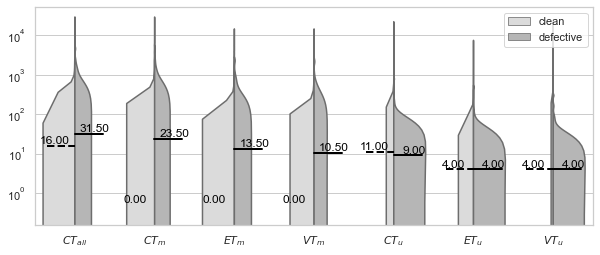

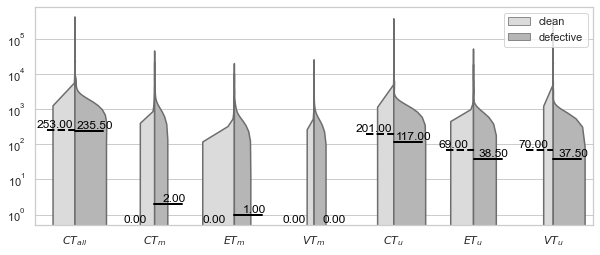

In [82]:

metrics_dict = {'TL': '$CT_{all}$', 'TL-CL': '$CT_{m}$', 'TL-UL': '$CT_{u}$', 'ATL-CL': '$ET_{m}$', 'DTL-CL': '$VT_{m}$', 'ATL-UL': '$ET_{u}$', 'DTL-UL': '$VT_{u}$'}
for project in ['Lang', 'Math']:
    df = ccms2df(project)
    foldfile = os.path.join("data_info/{}.5.Nfold.json".format(project))
    with open(foldfile) as f:
        n_clabel_folds = json.load(f)
    # entire fix-inducing and non-inducing commits
    fix_induc_commits = [commit for clabels in n_clabel_folds.values() for commit in clabels['fix_induc']]
    non_induc_commits = [commit for clabels in n_clabel_folds.values() for commit in clabels['not_fix_induc']]
    df = df[df['commit'].isin(fix_induc_commits+non_induc_commits)]
    df_melt = df[['commit', 'label', 'TL', 'TL-CL', 'TL-UL', 'ATL-CL', 'DTL-CL', 'ATL-UL', 'DTL-UL']].melt(id_vars=['commit', 'label'], var_name='indicator')
    df_melt['indicator'] = df_melt['indicator'].map(metrics_dict)
    plot_violin(df_melt, project)


# RQ2. Effectiveness

Here, we evaluate the effectivenss of trained models. For the model training, run ```./run_model_w_ir_allconfig.sh``` to train models with _sim2r_ metrics, and run ```./run_model_baseline_final.sh``` to train models without _sim2r_ metrics.

In [38]:
repos = {'Lang':'repos/commons-lang',
        'Math':'repos/commons-math'}

In [39]:
## clone the repo if it doesn't exist already
import git

os.makedirs('repos', exist_ok = True)
if not os.path.exists(repos['Lang']):
    git.Git("repos").clone("https://github.com/apache/commons-lang.git")
if not os.path.exists(repos['Math']):
    git.Git("repos").clone("https://github.com/apache/commons-math.git")

#### For creating the baseline models
$1 (= use\_scale (min-max scaler): 1 (default), 0 (raw)

$2 (= N (the number of folds)): 5

$3 (= project)

$4 (= algo): RF (default)

$5 (= use\_only\_recent (since we use all commits in previous folds, default is 0): 0 (all previous), 1 (closest)

$6 (= repo): use ```repos[project]``` 

$7 (= num): 29 (default) (the number of iterations(30) - 1)

$8 (= use_only_previous): 0 (defaut) 


**e.g.,**
```./run_model_baseline_final.sh 1 5 Lang RF 0 repos/commons-lang 29 0```

The results will be stored under ```results/base/project/RF/None```. 

#### For creating the models with report features

$1 (= use\_scale (min-max scaler): 1 (default), 0 (raw)

$2 (= N (the number of folds)): 5

$3 (= project)

$4 (= algo): RF (default)

$5 (= use\_only\_recent (since we use all commits in previous folds, default is 0): 0 (all previous), 1 (closest)

$6 (= max\_days): 30, 60, 90, 120 days

$7 (= repo): use ```repos[project]```

$8 (= num): 29 (default) (the number of iterations(30) - 1)

$9 (= use_only_previous): 0 (defaut) 

**e.g.,** 
```./run_model_w_ir_allconfig.sh 1 5 Lang RF 0 90 repos/commons-lang 29 0 ```

The results will be stored under ```results/w_irfl/project/RF/None/max_days```. 

#### For creating the models with trace features

$1 (= use\_scale (min-max scaler): 1 (default), 0 (raw)

$2 (= N (the number of folds)): 5

$3 (= project)

$4 (= algo): RF (default)

$5 (= use\_only\_recent (since we use all commits in previous folds, default is 0): 0 (all previous), 1 (closest)

$6 (= repo): use ```repos[project]```

$7 (= num): 29 (default) (the number of iterations(30) - 1)

$8 (= use_only_previous): 0 (defaut) 

**e.g.,** 
```./run_model_w_tjit_final.sh 1 5 Lang RF 0 repos/commons-lang 29 0```

The results will be stored under ```results/w_tjit/project/RF/None```. 

Retrieve evaluation results (under the _stat_ directory) and plot them 

In [84]:
root_base_stat_dir = "results/base"
root_stat_dir = "results/w_irfl"
root_tjit_stat_dir = "results/w_tjit"

In [41]:
def get_eval_stat_from_iters(statfile_format, project, idx_to_fold, eval_mth, iter_num = 30):
    """
    """
    vals = []
    for i in range(iter_num):
        try:
            statfile = statfile_format.format(project, idx_to_fold, i)
            stat_df = pd.read_csv(statfile)
            vals.append(np.float32(stat_df[eval_mth][0]) if stat_df[eval_mth][0] != -1 else np.float32(0))
        except FileNotFoundError as e:
            print(e)
            pass
    
    return vals

In [42]:
stat_dir = os.path.join(root_stat_dir, "{}/RF/None/{}/stat".format('Lang', 30)) 

In [43]:
def summarise_stat(project, max_days, idx_to_fold):

    import pandas as pd
    base_stat_dir = os.path.join(root_base_stat_dir, "{}/RF/None/stat".format(project))  
    stat_dir = os.path.join(root_stat_dir, "{}/RF/None/{}/stat".format(project, max_days)) 
    tjit_stat_dir = os.path.join(root_tjit_stat_dir, "{}/RF/None/stat".format(project))
    
    results = {'tech':[], 'base':[], 'tjit':[], 'diff':[]}
    
    for eval_mth in ['AUC', 'Acc', 'Precision', 'Recall', 'Bal_Acc', 'F1', 'PR_score']: 
        base_results = np.asarray(
            get_eval_stat_from_iters(
            os.path.join(base_stat_dir,"{}.RF.{}.base.None.RF.N5.{}.stat"), project, idx_to_fold, eval_mth))
        
        tjit_results = np.asarray(
            get_eval_stat_from_iters(
            os.path.join(tjit_stat_dir,"{}.RF.{}.tjit.not_weighted.None.RF.N5.{}.stat"), project, idx_to_fold, eval_mth))
        
        diff_results = np.asarray(
            get_eval_stat_from_iters(
                os.path.join(stat_dir,"{}.RF.{}.diff.not_weighted.None.RF.N5.{}.stat"),
                project, idx_to_fold, eval_mth))
        
        
        results['tech'].append(eval_mth)
        results['base'].append(np.mean(base_results))
        results['tjit'].append(np.mean(tjit_results))
        results['diff'].append(np.mean(diff_results)) 
        
    df = pd.DataFrame(results)
    df = df.set_index('tech')
    return df

In [44]:
def get_evaluation_result(project, max_days):
    """
    """
    content = "| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |\n"
    content += "|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|\n"
    content += "|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |\n"

    techs = ['base', 'diff', 'tjit']
    eval_mths = ['AUC', 'Acc', 'Precision', 'Recall', 'Bal_Acc','F1', 'PR_score']
    eval_result_per_fold = {}
    indices_to_fold = [0,1,2,3,'all']
    for idx_to_fold in indices_to_fold:
        eval_result_per_fold[idx_to_fold] = summarise_stat(project, max_days, idx_to_fold)
    
    
    for i, eval_mth in enumerate(eval_mths):
        if i == int(len(eval_mths)/2):
            line = "|{} |{} days|{}|".format(project, max_days, eval_mth)
        else:
            line = "| |  |{}|".format(eval_mth)
        
        for idx_to_fold in indices_to_fold:
            target_row = eval_result_per_fold[idx_to_fold].loc[eval_mth]
            for tech in techs:
                if tech == 'base':
                    base_v = target_row[tech]
                    base_v = np.around(base_v, decimals = 3)
                
                if eval_mth != 'Brier':
                    best_v = np.around(np.max(list(target_row)), decimals = 3)
                    #if np.around(target_row[tech], decimals = 3) > base_v and tech != 'base':
                    if  tech != 'base':
                        if np.around(target_row[tech], decimals = 3) > base_v:
                            v_print = "**<font color='red'>" + "{0:.3f}".format(target_row[tech])# + "</font>"
                            # v_print_in_perc = "<font color='black'>" + "(" + "{0:.1f}".format(np.round(100*(np.around(target_row[tech], decimals = 3) - base_v)/base_v,1)) + "%)" + "</font>**"
                            v_print_in_perc = "(" + "{0:.1f}".format(np.round(100*(np.around(target_row[tech], decimals = 3) - base_v)/base_v,1)) + "%)" + "</font>**"
                        elif np.around(target_row[tech], decimals = 3)  <= 0:
                            v_print = "**<font color='black'>" + "{0:.3f}".format(target_row[tech])
                            v_print_in_perc = "()" + "</font>**"
                        else:
                            v_print = "**<font color='black'>" + "{0:.3f}".format(target_row[tech]) 
                            v_print_in_perc = "(" +"{0:.1f}".format(np.round(100*(np.around(target_row[tech], decimals = 3) - base_v)/base_v,1)) + "%)" + "</font>**"
                    else:
                        v_print = "**<font color='black'>" + "{0:.3f}".format(target_row[tech]) + "</font>**"
                        v_print_in_perc = ""
                        #v_print_in_perc = "{0:.1f}".format(np.round(100*(target_row[tech] - base_v)/base_v,1)) + "%"
                else:
                    best_v = np.around(np.min(target_row), decimals = 3)
                    if np.around(target_row[tech], decimals = 3) < base_v and tech != 'base':
                        v_print = "**<font color='red'>" + "{0:.3f}".format(target_row[tech]) + "</font>"
                        v_print_in_perc = "<font color='black'>" + "{0:.1f}".format(np.round(100*(base_v - best_v)/base_v,1)) + "%" + "</font>**"
                    else:
                        v_print = "**<font color='black'>" + "{0:.3f}".format(target_row[tech]) + "</font>"
                        v_print_in_perc = "<font color='black'>" + " - " + "</font>**"
                        #v_print_in_perc = "{0:.1f}".format(np.round(100*(base_v - target_row[tech])/base_v,1)) + "%"
                line += "{}{}|".format(v_print, v_print_in_perc)
                
        line += "\n"
        content += line
    
    display(Markdown(content))
    return eval_result_per_fold


In [86]:
for project in ['Lang', 'Math']:
    for max_days in [30,60,90,120]:   
         _ = get_evaluation_result(project, max_days)
    
    print ("\n")

| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.611</font>**|**<font color='black'>0.600(-1.8%)</font>**|**<font color='red'>0.775(26.8%)</font>**|**<font color='black'>0.708</font>**|**<font color='red'>0.726(2.5%)</font>**|**<font color='red'>0.723(2.1%)</font>**|**<font color='black'>0.653</font>**|**<font color='red'>0.697(6.7%)</font>**|**<font color='red'>0.686(5.1%)</font>**|**<font color='black'>0.689</font>**|**<font color='red'>0.758(10.0%)</font>**|**<font color='red'>0.715(3.8%)</font>**|**<font color='black'>0.674</font>**|**<font color='red'>0.715(6.1%)</font>**|**<font color='red'>0.714(5.9%)</font>**|
| |  |Acc|**<font color='black'>0.984</font>**|**<font color='black'>0.984(0.0%)</font>**|**<font color='black'>0.984(0.0%)</font>**|**<font color='black'>0.974</font>**|**<font color='black'>0.973(-0.1%)</font>**|**<font color='black'>0.973(-0.1%)</font>**|**<font color='black'>0.941</font>**|**<font color='black'>0.941(0.0%)</font>**|**<font color='red'>0.945(0.4%)</font>**|**<font color='black'>0.958</font>**|**<font color='black'>0.957(-0.1%)</font>**|**<font color='red'>0.959(0.1%)</font>**|**<font color='black'>0.964</font>**|**<font color='black'>0.964(0.0%)</font>**|**<font color='red'>0.965(0.1%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.300</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='red'>0.250(88.0%)</font>**|**<font color='red'>0.650(388.7%)</font>**|**<font color='black'>0.233</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.286</font>**|**<font color='black'>0.136(-52.4%)</font>**|**<font color='red'>0.414(44.8%)</font>**|
|Lang |30 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.030</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.003(-90.0%)</font>**|**<font color='black'>0.011</font>**|**<font color='red'>0.024(118.2%)</font>**|**<font color='red'>0.032(190.9%)</font>**|**<font color='black'>0.048</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.024</font>**|**<font color='black'>0.010(-58.3%)</font>**|**<font color='black'>0.014(-41.7%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.515</font>**|**<font color='black'>0.500(-2.9%)</font>**|**<font color='black'>0.502(-2.5%)</font>**|**<font color='black'>0.504</font>**|**<font color='red'>0.510(1.2%)</font>**|**<font color='red'>0.516(2.4%)</font>**|**<font color='black'>0.521</font>**|**<font color='black'>0.497(-4.6%)</font>**|**<font color='black'>0.499(-4.2%)</font>**|**<font color='black'>0.511</font>**|**<font color='black'>0.504(-1.4%)</font>**|**<font color='black'>0.507(-0.8%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.055</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.006(-89.1%)</font>**|**<font color='black'>0.020</font>**|**<font color='red'>0.043(115.0%)</font>**|**<font color='red'>0.060(200.0%)</font>**|**<font color='black'>0.079</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.043</font>**|**<font color='black'>0.018(-58.1%)</font>**|**<font color='black'>0.026(-39.5%)</font>**|
| |  |PR_score|**<font color='black'>0.280</font>**|**<font color='black'>0.130(-53.6%)</font>**|**<font color='red'>0.284(1.4%)</font>**|**<font color='black'>0.384</font>**|**<font color='black'>0.368(-4.2%)</font>**|**<font color='black'>0.329(-14.3%)</font>**|**<font color='black'>0.125</font>**|**<font color='red'>0.134(7.2%)</font>**|**<font color='red'>0.161(28.8%)</font>**|**<font color='black'>0.100</font>**|**<font color='red'>0.116(16.0%)</font>**|**<font color='red'>0.105(5.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.126(-5.3%)</font>**|**<font color='red'>0.134(0.8%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.611</font>**|**<font color='red'>0.690(12.9%)</font>**|**<font color='red'>0.775(26.8%)</font>**|**<font color='black'>0.708</font>**|**<font color='red'>0.711(0.4%)</font>**|**<font color='red'>0.723(2.1%)</font>**|**<font color='black'>0.653</font>**|**<font color='red'>0.667(2.1%)</font>**|**<font color='red'>0.686(5.1%)</font>**|**<font color='black'>0.689</font>**|**<font color='red'>0.758(10.0%)</font>**|**<font color='red'>0.715(3.8%)</font>**|**<font color='black'>0.674</font>**|**<font color='red'>0.710(5.3%)</font>**|**<font color='red'>0.714(5.9%)</font>**|
| |  |Acc|**<font color='black'>0.984</font>**|**<font color='black'>0.984(0.0%)</font>**|**<font color='black'>0.984(0.0%)</font>**|**<font color='black'>0.974</font>**|**<font color='black'>0.973(-0.1%)</font>**|**<font color='black'>0.973(-0.1%)</font>**|**<font color='black'>0.941</font>**|**<font color='black'>0.941(0.0%)</font>**|**<font color='red'>0.945(0.4%)</font>**|**<font color='black'>0.958</font>**|**<font color='black'>0.958(0.0%)</font>**|**<font color='red'>0.959(0.1%)</font>**|**<font color='black'>0.964</font>**|**<font color='black'>0.964(0.0%)</font>**|**<font color='red'>0.965(0.1%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.300</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.050(-62.4%)</font>**|**<font color='red'>0.650(388.7%)</font>**|**<font color='black'>0.233</font>**|**<font color='black'>0.144(-38.2%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.286</font>**|**<font color='black'>0.131(-54.2%)</font>**|**<font color='red'>0.414(44.8%)</font>**|
|Lang |60 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.030</font>**|**<font color='black'>0.003(-90.0%)</font>**|**<font color='black'>0.003(-90.0%)</font>**|**<font color='black'>0.011</font>**|**<font color='black'>0.005(-54.5%)</font>**|**<font color='red'>0.032(190.9%)</font>**|**<font color='black'>0.048</font>**|**<font color='black'>0.031(-35.4%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.024</font>**|**<font color='black'>0.011(-54.2%)</font>**|**<font color='black'>0.014(-41.7%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.515</font>**|**<font color='black'>0.502(-2.5%)</font>**|**<font color='black'>0.502(-2.5%)</font>**|**<font color='black'>0.504</font>**|**<font color='black'>0.501(-0.6%)</font>**|**<font color='red'>0.516(2.4%)</font>**|**<font color='black'>0.521</font>**|**<font color='black'>0.513(-1.5%)</font>**|**<font color='black'>0.499(-4.2%)</font>**|**<font color='black'>0.511</font>**|**<font color='black'>0.504(-1.4%)</font>**|**<font color='black'>0.507(-0.8%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.055</font>**|**<font color='black'>0.006(-89.1%)</font>**|**<font color='black'>0.006(-89.1%)</font>**|**<font color='black'>0.020</font>**|**<font color='black'>0.009(-55.0%)</font>**|**<font color='red'>0.060(200.0%)</font>**|**<font color='black'>0.079</font>**|**<font color='black'>0.051(-35.4%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.043</font>**|**<font color='black'>0.020(-53.5%)</font>**|**<font color='black'>0.026(-39.5%)</font>**|
| |  |PR_score|**<font color='black'>0.280</font>**|**<font color='black'>0.170(-39.3%)</font>**|**<font color='red'>0.284(1.4%)</font>**|**<font color='black'>0.384</font>**|**<font color='black'>0.311(-19.0%)</font>**|**<font color='black'>0.329(-14.3%)</font>**|**<font color='black'>0.125</font>**|**<font color='black'>0.117(-6.4%)</font>**|**<font color='red'>0.161(28.8%)</font>**|**<font color='black'>0.100</font>**|**<font color='red'>0.121(21.0%)</font>**|**<font color='red'>0.105(5.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.129(-3.0%)</font>**|**<font color='red'>0.134(0.8%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.611</font>**|**<font color='red'>0.634(3.8%)</font>**|**<font color='red'>0.775(26.8%)</font>**|**<font color='black'>0.708</font>**|**<font color='red'>0.717(1.3%)</font>**|**<font color='red'>0.723(2.1%)</font>**|**<font color='black'>0.653</font>**|**<font color='black'>0.622(-4.7%)</font>**|**<font color='red'>0.686(5.1%)</font>**|**<font color='black'>0.689</font>**|**<font color='red'>0.734(6.5%)</font>**|**<font color='red'>0.715(3.8%)</font>**|**<font color='black'>0.674</font>**|**<font color='red'>0.683(1.3%)</font>**|**<font color='red'>0.714(5.9%)</font>**|
| |  |Acc|**<font color='black'>0.984</font>**|**<font color='black'>0.984(0.0%)</font>**|**<font color='black'>0.984(0.0%)</font>**|**<font color='black'>0.974</font>**|**<font color='black'>0.974(0.0%)</font>**|**<font color='black'>0.973(-0.1%)</font>**|**<font color='black'>0.941</font>**|**<font color='black'>0.941(0.0%)</font>**|**<font color='red'>0.945(0.4%)</font>**|**<font color='black'>0.958</font>**|**<font color='black'>0.958(0.0%)</font>**|**<font color='red'>0.959(0.1%)</font>**|**<font color='black'>0.964</font>**|**<font color='black'>0.964(0.0%)</font>**|**<font color='red'>0.965(0.1%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.300</font>**|**<font color='red'>0.367(22.3%)</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.133(0.0%)</font>**|**<font color='red'>0.650(388.7%)</font>**|**<font color='black'>0.233</font>**|**<font color='black'>0.111(-52.4%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.286</font>**|**<font color='black'>0.231(-19.2%)</font>**|**<font color='red'>0.414(44.8%)</font>**|
|Lang |90 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.030</font>**|**<font color='red'>0.037(23.3%)</font>**|**<font color='black'>0.003(-90.0%)</font>**|**<font color='black'>0.011</font>**|**<font color='red'>0.013(18.2%)</font>**|**<font color='red'>0.032(190.9%)</font>**|**<font color='black'>0.048</font>**|**<font color='black'>0.021(-56.3%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.024</font>**|**<font color='black'>0.018(-25.0%)</font>**|**<font color='black'>0.014(-41.7%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.515</font>**|**<font color='red'>0.518(0.6%)</font>**|**<font color='black'>0.502(-2.5%)</font>**|**<font color='black'>0.504</font>**|**<font color='red'>0.505(0.2%)</font>**|**<font color='red'>0.516(2.4%)</font>**|**<font color='black'>0.521</font>**|**<font color='black'>0.508(-2.5%)</font>**|**<font color='black'>0.499(-4.2%)</font>**|**<font color='black'>0.511</font>**|**<font color='black'>0.508(-0.6%)</font>**|**<font color='black'>0.507(-0.8%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.055</font>**|**<font color='red'>0.067(21.8%)</font>**|**<font color='black'>0.006(-89.1%)</font>**|**<font color='black'>0.020</font>**|**<font color='red'>0.023(15.0%)</font>**|**<font color='red'>0.060(200.0%)</font>**|**<font color='black'>0.079</font>**|**<font color='black'>0.036(-54.4%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.043</font>**|**<font color='black'>0.034(-20.9%)</font>**|**<font color='black'>0.026(-39.5%)</font>**|
| |  |PR_score|**<font color='black'>0.280</font>**|**<font color='black'>0.257(-8.2%)</font>**|**<font color='red'>0.284(1.4%)</font>**|**<font color='black'>0.384</font>**|**<font color='red'>0.388(1.0%)</font>**|**<font color='black'>0.329(-14.3%)</font>**|**<font color='black'>0.125</font>**|**<font color='black'>0.114(-8.8%)</font>**|**<font color='red'>0.161(28.8%)</font>**|**<font color='black'>0.100</font>**|**<font color='red'>0.123(23.0%)</font>**|**<font color='red'>0.105(5.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='red'>0.142(6.8%)</font>**|**<font color='red'>0.134(0.8%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.611</font>**|**<font color='red'>0.855(39.9%)</font>**|**<font color='red'>0.775(26.8%)</font>**|**<font color='black'>0.708</font>**|**<font color='red'>0.726(2.5%)</font>**|**<font color='red'>0.723(2.1%)</font>**|**<font color='black'>0.653</font>**|**<font color='black'>0.624(-4.4%)</font>**|**<font color='red'>0.686(5.1%)</font>**|**<font color='black'>0.689</font>**|**<font color='red'>0.724(5.1%)</font>**|**<font color='red'>0.715(3.8%)</font>**|**<font color='black'>0.674</font>**|**<font color='red'>0.705(4.6%)</font>**|**<font color='red'>0.714(5.9%)</font>**|
| |  |Acc|**<font color='black'>0.984</font>**|**<font color='black'>0.984(0.0%)</font>**|**<font color='black'>0.984(0.0%)</font>**|**<font color='black'>0.974</font>**|**<font color='black'>0.974(0.0%)</font>**|**<font color='black'>0.973(-0.1%)</font>**|**<font color='black'>0.941</font>**|**<font color='red'>0.942(0.1%)</font>**|**<font color='red'>0.945(0.4%)</font>**|**<font color='black'>0.958</font>**|**<font color='red'>0.959(0.1%)</font>**|**<font color='red'>0.959(0.1%)</font>**|**<font color='black'>0.964</font>**|**<font color='red'>0.965(0.1%)</font>**|**<font color='red'>0.965(0.1%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.300</font>**|**<font color='red'>0.500(66.7%)</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='red'>0.150(12.8%)</font>**|**<font color='red'>0.650(388.7%)</font>**|**<font color='black'>0.233</font>**|**<font color='red'>0.294(26.2%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.286</font>**|**<font color='red'>0.379(32.5%)</font>**|**<font color='red'>0.414(44.8%)</font>**|
|Lang |120 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.030</font>**|**<font color='red'>0.050(66.7%)</font>**|**<font color='black'>0.003(-90.0%)</font>**|**<font color='black'>0.011</font>**|**<font color='black'>0.010(-9.1%)</font>**|**<font color='red'>0.032(190.9%)</font>**|**<font color='black'>0.048</font>**|**<font color='red'>0.060(25.0%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.024</font>**|**<font color='red'>0.030(25.0%)</font>**|**<font color='black'>0.014(-41.7%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.515</font>**|**<font color='red'>0.525(1.9%)</font>**|**<font color='black'>0.502(-2.5%)</font>**|**<font color='black'>0.504</font>**|**<font color='black'>0.504(0.0%)</font>**|**<font color='red'>0.516(2.4%)</font>**|**<font color='black'>0.521</font>**|**<font color='red'>0.527(1.2%)</font>**|**<font color='black'>0.499(-4.2%)</font>**|**<font color='black'>0.511</font>**|**<font color='red'>0.514(0.6%)</font>**|**<font color='black'>0.507(-0.8%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.055</font>**|**<font color='red'>0.091(65.5%)</font>**|**<font color='black'>0.006(-89.1%)</font>**|**<font color='black'>0.020</font>**|**<font color='black'>0.018(-10.0%)</font>**|**<font color='red'>0.060(200.0%)</font>**|**<font color='black'>0.079</font>**|**<font color='red'>0.099(25.3%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.043</font>**|**<font color='red'>0.056(30.2%)</font>**|**<font color='black'>0.026(-39.5%)</font>**|
| |  |PR_score|**<font color='black'>0.280</font>**|**<font color='red'>0.302(7.9%)</font>**|**<font color='red'>0.284(1.4%)</font>**|**<font color='black'>0.384</font>**|**<font color='red'>0.400(4.2%)</font>**|**<font color='black'>0.329(-14.3%)</font>**|**<font color='black'>0.125</font>**|**<font color='black'>0.116(-7.2%)</font>**|**<font color='red'>0.161(28.8%)</font>**|**<font color='black'>0.100</font>**|**<font color='red'>0.107(7.0%)</font>**|**<font color='red'>0.105(5.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='red'>0.134(0.8%)</font>**|**<font color='red'>0.134(0.8%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.763</font>**|**<font color='black'>0.754(-1.2%)</font>**|**<font color='black'>0.758(-0.7%)</font>**|**<font color='black'>0.726</font>**|**<font color='red'>0.731(0.7%)</font>**|**<font color='red'>0.743(2.3%)</font>**|**<font color='black'>0.774</font>**|**<font color='black'>0.758(-2.1%)</font>**|**<font color='black'>0.766(-1.0%)</font>**|**<font color='black'>0.760</font>**|**<font color='red'>0.771(1.4%)</font>**|**<font color='red'>0.775(2.0%)</font>**|**<font color='black'>0.762</font>**|**<font color='red'>0.763(0.1%)</font>**|**<font color='red'>0.772(1.3%)</font>**|
| |  |Acc|**<font color='black'>0.944</font>**|**<font color='red'>0.946(0.2%)</font>**|**<font color='red'>0.945(0.1%)</font>**|**<font color='black'>0.979</font>**|**<font color='black'>0.978(-0.1%)</font>**|**<font color='black'>0.974(-0.5%)</font>**|**<font color='black'>0.947</font>**|**<font color='red'>0.948(0.1%)</font>**|**<font color='black'>0.946(-0.1%)</font>**|**<font color='black'>0.888</font>**|**<font color='red'>0.894(0.7%)</font>**|**<font color='red'>0.889(0.1%)</font>**|**<font color='black'>0.940</font>**|**<font color='red'>0.942(0.2%)</font>**|**<font color='black'>0.939(-0.1%)</font>**|
| |  |Precision|**<font color='black'>0.411</font>**|**<font color='red'>0.517(25.8%)</font>**|**<font color='red'>0.482(17.3%)</font>**|**<font color='black'>0.283</font>**|**<font color='red'>0.303(7.1%)</font>**|**<font color='black'>0.181(-36.0%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.180</font>**|**<font color='red'>0.333(85.0%)</font>**|**<font color='red'>0.320(77.8%)</font>**|**<font color='black'>0.213</font>**|**<font color='red'>0.307(44.1%)</font>**|**<font color='red'>0.272(27.7%)</font>**|
|Math |30 days|Recall|**<font color='black'>0.038</font>**|**<font color='black'>0.014(-63.2%)</font>**|**<font color='black'>0.037(-2.6%)</font>**|**<font color='black'>0.033</font>**|**<font color='red'>0.071(115.2%)</font>**|**<font color='red'>0.071(115.2%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.029</font>**|**<font color='red'>0.038(31.0%)</font>**|**<font color='red'>0.080(175.9%)</font>**|**<font color='black'>0.025</font>**|**<font color='red'>0.027(8.0%)</font>**|**<font color='red'>0.051(104.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.518</font>**|**<font color='black'>0.507(-2.1%)</font>**|**<font color='black'>0.517(-0.2%)</font>**|**<font color='black'>0.516</font>**|**<font color='red'>0.534(3.5%)</font>**|**<font color='red'>0.532(3.1%)</font>**|**<font color='black'>0.498</font>**|**<font color='red'>0.499(0.2%)</font>**|**<font color='black'>0.498(0.0%)</font>**|**<font color='black'>0.507</font>**|**<font color='red'>0.515(1.6%)</font>**|**<font color='red'>0.530(4.5%)</font>**|**<font color='black'>0.510</font>**|**<font color='red'>0.512(0.4%)</font>**|**<font color='red'>0.521(2.2%)</font>**|
| |  |F1|**<font color='black'>0.070</font>**|**<font color='black'>0.027(-61.4%)</font>**|**<font color='black'>0.068(-2.9%)</font>**|**<font color='black'>0.058</font>**|**<font color='red'>0.115(98.3%)</font>**|**<font color='red'>0.099(70.7%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.049</font>**|**<font color='red'>0.068(38.8%)</font>**|**<font color='red'>0.127(159.2%)</font>**|**<font color='black'>0.045</font>**|**<font color='red'>0.049(8.9%)</font>**|**<font color='red'>0.086(91.1%)</font>**|
| |  |PR_score|**<font color='black'>0.173</font>**|**<font color='red'>0.203(17.3%)</font>**|**<font color='red'>0.190(9.8%)</font>**|**<font color='black'>0.084</font>**|**<font color='red'>0.091(8.3%)</font>**|**<font color='red'>0.112(33.3%)</font>**|**<font color='black'>0.176</font>**|**<font color='black'>0.169(-4.0%)</font>**|**<font color='black'>0.140(-20.5%)</font>**|**<font color='black'>0.246</font>**|**<font color='red'>0.261(6.1%)</font>**|**<font color='red'>0.282(14.6%)</font>**|**<font color='black'>0.149</font>**|**<font color='red'>0.161(8.1%)</font>**|**<font color='red'>0.170(14.1%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.763</font>**|**<font color='black'>0.749(-1.8%)</font>**|**<font color='black'>0.758(-0.7%)</font>**|**<font color='black'>0.726</font>**|**<font color='red'>0.739(1.8%)</font>**|**<font color='red'>0.743(2.3%)</font>**|**<font color='black'>0.774</font>**|**<font color='black'>0.735(-5.0%)</font>**|**<font color='black'>0.766(-1.0%)</font>**|**<font color='black'>0.760</font>**|**<font color='red'>0.766(0.8%)</font>**|**<font color='red'>0.775(2.0%)</font>**|**<font color='black'>0.762</font>**|**<font color='black'>0.755(-0.9%)</font>**|**<font color='red'>0.772(1.3%)</font>**|
| |  |Acc|**<font color='black'>0.944</font>**|**<font color='black'>0.944(0.0%)</font>**|**<font color='red'>0.945(0.1%)</font>**|**<font color='black'>0.979</font>**|**<font color='black'>0.978(-0.1%)</font>**|**<font color='black'>0.974(-0.5%)</font>**|**<font color='black'>0.947</font>**|**<font color='black'>0.947(0.0%)</font>**|**<font color='black'>0.946(-0.1%)</font>**|**<font color='black'>0.888</font>**|**<font color='red'>0.894(0.7%)</font>**|**<font color='red'>0.889(0.1%)</font>**|**<font color='black'>0.940</font>**|**<font color='red'>0.941(0.1%)</font>**|**<font color='black'>0.939(-0.1%)</font>**|
| |  |Precision|**<font color='black'>0.411</font>**|**<font color='black'>0.133(-67.6%)</font>**|**<font color='red'>0.482(17.3%)</font>**|**<font color='black'>0.283</font>**|**<font color='black'>0.183(-35.3%)</font>**|**<font color='black'>0.181(-36.0%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.180</font>**|**<font color='red'>0.289(60.6%)</font>**|**<font color='red'>0.320(77.8%)</font>**|**<font color='black'>0.213</font>**|**<font color='red'>0.218(2.3%)</font>**|**<font color='red'>0.272(27.7%)</font>**|
|Math |60 days|Recall|**<font color='black'>0.038</font>**|**<font color='black'>0.004(-89.5%)</font>**|**<font color='black'>0.037(-2.6%)</font>**|**<font color='black'>0.033</font>**|**<font color='black'>0.029(-12.1%)</font>**|**<font color='red'>0.071(115.2%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.029</font>**|**<font color='red'>0.035(20.7%)</font>**|**<font color='red'>0.080(175.9%)</font>**|**<font color='black'>0.025</font>**|**<font color='black'>0.019(-24.0%)</font>**|**<font color='red'>0.051(104.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.518</font>**|**<font color='black'>0.502(-3.1%)</font>**|**<font color='black'>0.517(-0.2%)</font>**|**<font color='black'>0.516</font>**|**<font color='black'>0.513(-0.6%)</font>**|**<font color='red'>0.532(3.1%)</font>**|**<font color='black'>0.498</font>**|**<font color='black'>0.498(0.0%)</font>**|**<font color='black'>0.498(0.0%)</font>**|**<font color='black'>0.507</font>**|**<font color='red'>0.513(1.2%)</font>**|**<font color='red'>0.530(4.5%)</font>**|**<font color='black'>0.510</font>**|**<font color='black'>0.508(-0.4%)</font>**|**<font color='red'>0.521(2.2%)</font>**|
| |  |F1|**<font color='black'>0.070</font>**|**<font color='black'>0.008(-88.6%)</font>**|**<font color='black'>0.068(-2.9%)</font>**|**<font color='black'>0.058</font>**|**<font color='black'>0.048(-17.2%)</font>**|**<font color='red'>0.099(70.7%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.049</font>**|**<font color='red'>0.062(26.5%)</font>**|**<font color='red'>0.127(159.2%)</font>**|**<font color='black'>0.045</font>**|**<font color='black'>0.035(-22.2%)</font>**|**<font color='red'>0.086(91.1%)</font>**|
| |  |PR_score|**<font color='black'>0.173</font>**|**<font color='black'>0.163(-5.8%)</font>**|**<font color='red'>0.190(9.8%)</font>**|**<font color='black'>0.084</font>**|**<font color='black'>0.067(-20.2%)</font>**|**<font color='red'>0.112(33.3%)</font>**|**<font color='black'>0.176</font>**|**<font color='black'>0.158(-10.2%)</font>**|**<font color='black'>0.140(-20.5%)</font>**|**<font color='black'>0.246</font>**|**<font color='red'>0.269(9.3%)</font>**|**<font color='red'>0.282(14.6%)</font>**|**<font color='black'>0.149</font>**|**<font color='red'>0.157(5.4%)</font>**|**<font color='red'>0.170(14.1%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.763</font>**|**<font color='black'>0.760(-0.4%)</font>**|**<font color='black'>0.758(-0.7%)</font>**|**<font color='black'>0.726</font>**|**<font color='red'>0.742(2.2%)</font>**|**<font color='red'>0.743(2.3%)</font>**|**<font color='black'>0.774</font>**|**<font color='black'>0.742(-4.1%)</font>**|**<font color='black'>0.766(-1.0%)</font>**|**<font color='black'>0.760</font>**|**<font color='red'>0.761(0.1%)</font>**|**<font color='red'>0.775(2.0%)</font>**|**<font color='black'>0.762</font>**|**<font color='black'>0.761(-0.1%)</font>**|**<font color='red'>0.772(1.3%)</font>**|
| |  |Acc|**<font color='black'>0.944</font>**|**<font color='black'>0.943(-0.1%)</font>**|**<font color='red'>0.945(0.1%)</font>**|**<font color='black'>0.979</font>**|**<font color='red'>0.980(0.1%)</font>**|**<font color='black'>0.974(-0.5%)</font>**|**<font color='black'>0.947</font>**|**<font color='black'>0.947(0.0%)</font>**|**<font color='black'>0.946(-0.1%)</font>**|**<font color='black'>0.888</font>**|**<font color='red'>0.892(0.5%)</font>**|**<font color='red'>0.889(0.1%)</font>**|**<font color='black'>0.940</font>**|**<font color='red'>0.941(0.1%)</font>**|**<font color='black'>0.939(-0.1%)</font>**|
| |  |Precision|**<font color='black'>0.411</font>**|**<font color='black'>0.000()</font>**|**<font color='red'>0.482(17.3%)</font>**|**<font color='black'>0.283</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.181(-36.0%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.180</font>**|**<font color='red'>0.334(85.6%)</font>**|**<font color='red'>0.320(77.8%)</font>**|**<font color='black'>0.213</font>**|**<font color='red'>0.257(20.7%)</font>**|**<font color='red'>0.272(27.7%)</font>**|
|Math |90 days|Recall|**<font color='black'>0.038</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.037(-2.6%)</font>**|**<font color='black'>0.033</font>**|**<font color='black'>0.000()</font>**|**<font color='red'>0.071(115.2%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.029</font>**|**<font color='red'>0.058(100.0%)</font>**|**<font color='red'>0.080(175.9%)</font>**|**<font color='black'>0.025</font>**|**<font color='red'>0.026(4.0%)</font>**|**<font color='red'>0.051(104.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.518</font>**|**<font color='black'>0.499(-3.7%)</font>**|**<font color='black'>0.517(-0.2%)</font>**|**<font color='black'>0.516</font>**|**<font color='black'>0.500(-3.1%)</font>**|**<font color='red'>0.532(3.1%)</font>**|**<font color='black'>0.498</font>**|**<font color='black'>0.498(0.0%)</font>**|**<font color='black'>0.498(0.0%)</font>**|**<font color='black'>0.507</font>**|**<font color='red'>0.522(3.0%)</font>**|**<font color='red'>0.530(4.5%)</font>**|**<font color='black'>0.510</font>**|**<font color='red'>0.511(0.2%)</font>**|**<font color='red'>0.521(2.2%)</font>**|
| |  |F1|**<font color='black'>0.070</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.068(-2.9%)</font>**|**<font color='black'>0.058</font>**|**<font color='black'>0.000()</font>**|**<font color='red'>0.099(70.7%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.049</font>**|**<font color='red'>0.098(100.0%)</font>**|**<font color='red'>0.127(159.2%)</font>**|**<font color='black'>0.045</font>**|**<font color='red'>0.047(4.4%)</font>**|**<font color='red'>0.086(91.1%)</font>**|
| |  |PR_score|**<font color='black'>0.173</font>**|**<font color='black'>0.141(-18.5%)</font>**|**<font color='red'>0.190(9.8%)</font>**|**<font color='black'>0.084</font>**|**<font color='black'>0.047(-44.0%)</font>**|**<font color='red'>0.112(33.3%)</font>**|**<font color='black'>0.176</font>**|**<font color='red'>0.177(0.6%)</font>**|**<font color='black'>0.140(-20.5%)</font>**|**<font color='black'>0.246</font>**|**<font color='red'>0.260(5.7%)</font>**|**<font color='red'>0.282(14.6%)</font>**|**<font color='black'>0.149</font>**|**<font color='red'>0.163(9.4%)</font>**|**<font color='red'>0.170(14.1%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.763</font>**|**<font color='black'>0.762(-0.1%)</font>**|**<font color='black'>0.758(-0.7%)</font>**|**<font color='black'>0.726</font>**|**<font color='black'>0.726(0.0%)</font>**|**<font color='red'>0.743(2.3%)</font>**|**<font color='black'>0.774</font>**|**<font color='black'>0.765(-1.2%)</font>**|**<font color='black'>0.766(-1.0%)</font>**|**<font color='black'>0.760</font>**|**<font color='red'>0.772(1.6%)</font>**|**<font color='red'>0.775(2.0%)</font>**|**<font color='black'>0.762</font>**|**<font color='red'>0.773(1.4%)</font>**|**<font color='red'>0.772(1.3%)</font>**|
| |  |Acc|**<font color='black'>0.944</font>**|**<font color='black'>0.942(-0.2%)</font>**|**<font color='red'>0.945(0.1%)</font>**|**<font color='black'>0.979</font>**|**<font color='black'>0.976(-0.3%)</font>**|**<font color='black'>0.974(-0.5%)</font>**|**<font color='black'>0.947</font>**|**<font color='red'>0.948(0.1%)</font>**|**<font color='black'>0.946(-0.1%)</font>**|**<font color='black'>0.888</font>**|**<font color='red'>0.889(0.1%)</font>**|**<font color='red'>0.889(0.1%)</font>**|**<font color='black'>0.940</font>**|**<font color='black'>0.939(-0.1%)</font>**|**<font color='black'>0.939(-0.1%)</font>**|
| |  |Precision|**<font color='black'>0.411</font>**|**<font color='black'>0.011(-97.3%)</font>**|**<font color='red'>0.482(17.3%)</font>**|**<font color='black'>0.283</font>**|**<font color='black'>0.033(-88.3%)</font>**|**<font color='black'>0.181(-36.0%)</font>**|**<font color='black'>0.000</font>**|**<font color='red'>0.028(inf%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.180</font>**|**<font color='red'>0.300(66.7%)</font>**|**<font color='red'>0.320(77.8%)</font>**|**<font color='black'>0.213</font>**|**<font color='red'>0.220(3.3%)</font>**|**<font color='red'>0.272(27.7%)</font>**|
|Math |120 days|Recall|**<font color='black'>0.038</font>**|**<font color='black'>0.001(-97.4%)</font>**|**<font color='black'>0.037(-2.6%)</font>**|**<font color='black'>0.033</font>**|**<font color='black'>0.007(-78.8%)</font>**|**<font color='red'>0.071(115.2%)</font>**|**<font color='black'>0.000</font>**|**<font color='red'>0.002(inf%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.029</font>**|**<font color='red'>0.066(127.6%)</font>**|**<font color='red'>0.080(175.9%)</font>**|**<font color='black'>0.025</font>**|**<font color='red'>0.031(24.0%)</font>**|**<font color='red'>0.051(104.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.518</font>**|**<font color='black'>0.499(-3.7%)</font>**|**<font color='black'>0.517(-0.2%)</font>**|**<font color='black'>0.516</font>**|**<font color='black'>0.502(-2.7%)</font>**|**<font color='red'>0.532(3.1%)</font>**|**<font color='black'>0.498</font>**|**<font color='red'>0.500(0.4%)</font>**|**<font color='black'>0.498(0.0%)</font>**|**<font color='black'>0.507</font>**|**<font color='red'>0.524(3.4%)</font>**|**<font color='red'>0.530(4.5%)</font>**|**<font color='black'>0.510</font>**|**<font color='red'>0.512(0.4%)</font>**|**<font color='red'>0.521(2.2%)</font>**|
| |  |F1|**<font color='black'>0.070</font>**|**<font color='black'>0.002(-97.1%)</font>**|**<font color='black'>0.068(-2.9%)</font>**|**<font color='black'>0.058</font>**|**<font color='black'>0.012(-79.3%)</font>**|**<font color='red'>0.099(70.7%)</font>**|**<font color='black'>0.000</font>**|**<font color='red'>0.004(inf%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.049</font>**|**<font color='red'>0.108(120.4%)</font>**|**<font color='red'>0.127(159.2%)</font>**|**<font color='black'>0.045</font>**|**<font color='red'>0.054(20.0%)</font>**|**<font color='red'>0.086(91.1%)</font>**|
| |  |PR_score|**<font color='black'>0.173</font>**|**<font color='black'>0.166(-4.0%)</font>**|**<font color='red'>0.190(9.8%)</font>**|**<font color='black'>0.084</font>**|**<font color='black'>0.052(-38.1%)</font>**|**<font color='red'>0.112(33.3%)</font>**|**<font color='black'>0.176</font>**|**<font color='red'>0.194(10.2%)</font>**|**<font color='black'>0.140(-20.5%)</font>**|**<font color='black'>0.246</font>**|**<font color='red'>0.267(8.5%)</font>**|**<font color='red'>0.282(14.6%)</font>**|**<font color='black'>0.149</font>**|**<font color='red'>0.173(16.1%)</font>**|**<font color='red'>0.170(14.1%)</font>**|


# Can TraceJIT detect regressions?

In [60]:
base_output_path = "results/base/{}/RF/None/output/{}.RF{}.base.None.RF.N5.{}.csv"
tjit_output_path = "results/w_tjit/{}/RF/None/output/{}.RF{}.tjit.not_weighted.None.RF.N5.{}.csv"
irfl_output_path = 'results/w_irfl/{}/RF/None/{}/output/{}.RF{}.diff.not_weighted.None.RF.N5.{}.csv'

In [61]:
def evaluate(predcs, prob, labels):
    """
    """
    from sklearn import metrics

    if len(set(labels)) == 1:
        auc_roc =  -1.
    else:
        auc_roc =  metrics.roc_auc_score(labels, prob)
    if 1 in predcs: # should predict at least one postive class
        prec =  metrics.precision_score(labels, predcs)
    else:
        prec =  -1.
    if 1 in labels: # should hava at least one positive class (1)
        recall =  metrics.recall_score(labels, predcs)
    else:
        recall =  -1.
    try:
        f1 =  metrics.f1_score(labels, predcs)
    except Exception as e:
        print (e)
        f1 =  -1.
    acc =  metrics.accuracy_score(labels, predcs)
    balanced_acc =  metrics.balanced_accuracy_score(labels, predcs)
    tn, fp, fn, tp = metrics.confusion_matrix(labels, predcs).ravel()
    tn_rate = tn/(tn + fp)
    pr_auc_score = metrics.average_precision_score(labels, prob)
    if np.isnan(pr_auc_score):
        pr_auc_score = -1.
    brier_score =  metrics.brier_score_loss(labels, prob) #smaller -> better
    
    return auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score

## Train: ALL commits, Test: MMCs

In [87]:
root_base_stat_dir = "results/base_MMC"
root_stat_dir = "results/w_irfl_MMC"
root_tjit_stat_dir = "results/w_tjit_MMC"
os.makedirs(root_base_stat_dir, exist_ok = True)
os.makedirs(root_stat_dir, exist_ok = True)
os.makedirs(root_tjit_stat_dir, exist_ok = True)

In [88]:
projects = ['Lang', 'Math']
days = ['30', '60', '90', '120']
is_clf = False
mmc = json.load(open('feature_data/MMCs/MMCs.json'))
for project in projects:
    for day in days:
        for i in range(30):
            for fold in ['0', '1', '2', '3', 'all']:
                f = '.'+fold if fold != 'all' else ''
                base_path = base_output_path.format(project, project, f, i)
                base_output = pd.read_csv(base_path)
                tjit_path = tjit_output_path.format(project, project, f, i)
                tjit_output = pd.read_csv(tjit_path)
                irfl_path = irfl_output_path.format(project, day, project, f, i)
                irfl_output = pd.read_csv(irfl_path)
                base_output = base_output[base_output['commit'].isin(mmc[project])]
                base_prob = base_output.prob.values
                base_pred = base_output.pred.values
                base_labels = base_output.label.values
                tjit_output = tjit_output[tjit_output['commit'].isin(mmc[project])]
                tjit_prob = tjit_output.prob.values
                tjit_pred = tjit_output.pred.values
                tjit_labels = tjit_output.label.values
                irfl_output = irfl_output[irfl_output['commit'].isin(mmc[project])]
                irfl_prob = irfl_output.prob.values
                irfl_pred = irfl_output.pred.values
                irfl_labels = irfl_output.label.values
                
                auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score = evaluate(base_pred, base_prob, base_labels)
                os.makedirs(f"results/base_MMC/{project}/RF/None/stat", exist_ok = True)
                stat_file_path = f"results/base_MMC/{project}/RF/None/stat/{project}.RF.{fold}.base.None.RF.N5.{i}.stat"
                with open(stat_file_path, 'w') as f:
                    f.write("AUC,Precision,Recall,F1,Brier,Acc,Bal_Acc,TN_Rate,PR_score\n")
                    f.write("{},{},{},{},{},{},{},{},{}\n".format(auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score))
                
                
                auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score = evaluate(tjit_pred, tjit_prob, tjit_labels)
                os.makedirs(f"results/w_tjit_MMC/{project}/RF/None/stat", exist_ok = True)
                stat_file_path = f"results/w_tjit_MMC/{project}/RF/None/stat/{project}.RF.{fold}.tjit.not_weighted.None.RF.N5.{i}.stat"
                with open(stat_file_path, 'w') as f:
                    f.write("AUC,Precision,Recall,F1,Brier,Acc,Bal_Acc,TN_Rate,PR_score\n")
                    f.write("{},{},{},{},{},{},{},{},{}\n".format(auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score))
                
                
                auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score = evaluate(irfl_pred, irfl_prob, irfl_labels)
                os.makedirs(f"results/w_irfl_MMC/{project}/RF/None/{day}/stat", exist_ok = True)
                stat_file_path = f"results/w_irfl_MMC/{project}/RF/None/{day}/stat/{project}.RF.{fold}.diff.not_weighted.None.RF.N5.{i}.stat"
                with open(stat_file_path, 'w') as f:
                    f.write("AUC,Precision,Recall,F1,Brier,Acc,Bal_Acc,TN_Rate,PR_score\n")
                    f.write("{},{},{},{},{},{},{},{},{}\n".format(auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score))

In [89]:
for project in ['Lang', 'Math']:
    for max_days in [30,60,90,120]:   
         _ = get_evaluation_result(project, max_days)
    
    print ("\n")

| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.676</font>**|**<font color='black'>0.618(-8.6%)</font>**|**<font color='red'>0.790(16.9%)</font>**|**<font color='black'>0.703</font>**|**<font color='red'>0.764(8.7%)</font>**|**<font color='red'>0.765(8.8%)</font>**|**<font color='black'>0.638</font>**|**<font color='red'>0.639(0.2%)</font>**|**<font color='red'>0.694(8.8%)</font>**|**<font color='black'>0.674</font>**|**<font color='black'>0.673(-0.1%)</font>**|**<font color='black'>0.670(-0.6%)</font>**|**<font color='black'>0.665</font>**|**<font color='red'>0.669(0.6%)</font>**|**<font color='red'>0.723(8.7%)</font>**|
| |  |Acc|**<font color='black'>0.980</font>**|**<font color='black'>0.980(0.0%)</font>**|**<font color='black'>0.980(0.0%)</font>**|**<font color='black'>0.983</font>**|**<font color='black'>0.982(-0.1%)</font>**|**<font color='black'>0.982(-0.1%)</font>**|**<font color='black'>0.975</font>**|**<font color='black'>0.975(0.0%)</font>**|**<font color='red'>0.980(0.5%)</font>**|**<font color='black'>0.974</font>**|**<font color='red'>0.975(0.1%)</font>**|**<font color='red'>0.978(0.4%)</font>**|**<font color='black'>0.978</font>**|**<font color='black'>0.978(0.0%)</font>**|**<font color='red'>0.980(0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.300</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='red'>0.250(88.0%)</font>**|**<font color='red'>0.650(388.7%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.129</font>**|**<font color='red'>0.136(5.4%)</font>**|**<font color='red'>0.414(220.9%)</font>**|
|Lang |30 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.060</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.007(-88.3%)</font>**|**<font color='black'>0.039</font>**|**<font color='red'>0.083(112.8%)</font>**|**<font color='red'>0.111(184.6%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.025</font>**|**<font color='black'>0.024(-4.0%)</font>**|**<font color='red'>0.033(32.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.530</font>**|**<font color='black'>0.500(-5.7%)</font>**|**<font color='black'>0.503(-5.1%)</font>**|**<font color='black'>0.518</font>**|**<font color='red'>0.540(4.2%)</font>**|**<font color='red'>0.555(7.1%)</font>**|**<font color='black'>0.496</font>**|**<font color='red'>0.497(0.2%)</font>**|**<font color='red'>0.498(0.4%)</font>**|**<font color='black'>0.511</font>**|**<font color='black'>0.511(0.0%)</font>**|**<font color='red'>0.516(1.0%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.100</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.011(-89.0%)</font>**|**<font color='black'>0.060</font>**|**<font color='red'>0.125(108.3%)</font>**|**<font color='red'>0.189(215.0%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.042</font>**|**<font color='black'>0.040(-4.8%)</font>**|**<font color='red'>0.061(45.2%)</font>**|
| |  |PR_score|**<font color='black'>0.357</font>**|**<font color='black'>0.204(-42.9%)</font>**|**<font color='red'>0.370(3.6%)</font>**|**<font color='black'>0.468</font>**|**<font color='black'>0.461(-1.5%)</font>**|**<font color='black'>0.466(-0.4%)</font>**|**<font color='black'>0.120</font>**|**<font color='red'>0.121(0.8%)</font>**|**<font color='red'>0.202(68.3%)</font>**|**<font color='black'>0.078</font>**|**<font color='black'>0.059(-24.4%)</font>**|**<font color='black'>0.073(-6.4%)</font>**|**<font color='black'>0.151</font>**|**<font color='black'>0.123(-18.5%)</font>**|**<font color='red'>0.169(11.9%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.676</font>**|**<font color='black'>0.669(-1.0%)</font>**|**<font color='red'>0.790(16.9%)</font>**|**<font color='black'>0.703</font>**|**<font color='red'>0.776(10.4%)</font>**|**<font color='red'>0.765(8.8%)</font>**|**<font color='black'>0.638</font>**|**<font color='black'>0.582(-8.8%)</font>**|**<font color='red'>0.694(8.8%)</font>**|**<font color='black'>0.674</font>**|**<font color='black'>0.671(-0.4%)</font>**|**<font color='black'>0.670(-0.6%)</font>**|**<font color='black'>0.665</font>**|**<font color='black'>0.664(-0.2%)</font>**|**<font color='red'>0.723(8.7%)</font>**|
| |  |Acc|**<font color='black'>0.980</font>**|**<font color='black'>0.980(0.0%)</font>**|**<font color='black'>0.980(0.0%)</font>**|**<font color='black'>0.983</font>**|**<font color='black'>0.982(-0.1%)</font>**|**<font color='black'>0.982(-0.1%)</font>**|**<font color='black'>0.975</font>**|**<font color='black'>0.974(-0.1%)</font>**|**<font color='red'>0.980(0.5%)</font>**|**<font color='black'>0.974</font>**|**<font color='black'>0.974(0.0%)</font>**|**<font color='red'>0.978(0.4%)</font>**|**<font color='black'>0.978</font>**|**<font color='black'>0.978(0.0%)</font>**|**<font color='red'>0.980(0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.300</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.050(-62.4%)</font>**|**<font color='red'>0.650(388.7%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.129</font>**|**<font color='black'>0.030(-76.7%)</font>**|**<font color='red'>0.414(220.9%)</font>**|
|Lang |60 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.060</font>**|**<font color='black'>0.007(-88.3%)</font>**|**<font color='black'>0.007(-88.3%)</font>**|**<font color='black'>0.039</font>**|**<font color='black'>0.017(-56.4%)</font>**|**<font color='red'>0.111(184.6%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.025</font>**|**<font color='black'>0.006(-76.0%)</font>**|**<font color='red'>0.033(32.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.530</font>**|**<font color='black'>0.503(-5.1%)</font>**|**<font color='black'>0.503(-5.1%)</font>**|**<font color='black'>0.518</font>**|**<font color='black'>0.507(-2.1%)</font>**|**<font color='red'>0.555(7.1%)</font>**|**<font color='black'>0.496</font>**|**<font color='black'>0.496(0.0%)</font>**|**<font color='red'>0.498(0.4%)</font>**|**<font color='black'>0.511</font>**|**<font color='black'>0.502(-1.8%)</font>**|**<font color='red'>0.516(1.0%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.100</font>**|**<font color='black'>0.011(-89.0%)</font>**|**<font color='black'>0.011(-89.0%)</font>**|**<font color='black'>0.060</font>**|**<font color='black'>0.025(-58.3%)</font>**|**<font color='red'>0.189(215.0%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.042</font>**|**<font color='black'>0.010(-76.2%)</font>**|**<font color='red'>0.061(45.2%)</font>**|
| |  |PR_score|**<font color='black'>0.357</font>**|**<font color='black'>0.314(-12.0%)</font>**|**<font color='red'>0.370(3.6%)</font>**|**<font color='black'>0.468</font>**|**<font color='black'>0.462(-1.3%)</font>**|**<font color='black'>0.466(-0.4%)</font>**|**<font color='black'>0.120</font>**|**<font color='black'>0.109(-9.2%)</font>**|**<font color='red'>0.202(68.3%)</font>**|**<font color='black'>0.078</font>**|**<font color='black'>0.053(-32.1%)</font>**|**<font color='black'>0.073(-6.4%)</font>**|**<font color='black'>0.151</font>**|**<font color='black'>0.123(-18.5%)</font>**|**<font color='red'>0.169(11.9%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.676</font>**|**<font color='red'>0.703(4.0%)</font>**|**<font color='red'>0.790(16.9%)</font>**|**<font color='black'>0.703</font>**|**<font color='red'>0.751(6.8%)</font>**|**<font color='red'>0.765(8.8%)</font>**|**<font color='black'>0.638</font>**|**<font color='black'>0.571(-10.5%)</font>**|**<font color='red'>0.694(8.8%)</font>**|**<font color='black'>0.674</font>**|**<font color='black'>0.672(-0.3%)</font>**|**<font color='black'>0.670(-0.6%)</font>**|**<font color='black'>0.665</font>**|**<font color='black'>0.663(-0.3%)</font>**|**<font color='red'>0.723(8.7%)</font>**|
| |  |Acc|**<font color='black'>0.980</font>**|**<font color='black'>0.980(0.0%)</font>**|**<font color='black'>0.980(0.0%)</font>**|**<font color='black'>0.983</font>**|**<font color='black'>0.983(0.0%)</font>**|**<font color='black'>0.982(-0.1%)</font>**|**<font color='black'>0.975</font>**|**<font color='black'>0.975(0.0%)</font>**|**<font color='red'>0.980(0.5%)</font>**|**<font color='black'>0.974</font>**|**<font color='red'>0.975(0.1%)</font>**|**<font color='red'>0.978(0.4%)</font>**|**<font color='black'>0.978</font>**|**<font color='black'>0.978(0.0%)</font>**|**<font color='red'>0.980(0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.300</font>**|**<font color='red'>0.367(22.3%)</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.133(0.0%)</font>**|**<font color='red'>0.650(388.7%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.129</font>**|**<font color='red'>0.157(21.7%)</font>**|**<font color='red'>0.414(220.9%)</font>**|
|Lang |90 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.060</font>**|**<font color='red'>0.073(21.7%)</font>**|**<font color='black'>0.007(-88.3%)</font>**|**<font color='black'>0.039</font>**|**<font color='red'>0.044(12.8%)</font>**|**<font color='red'>0.111(184.6%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.025</font>**|**<font color='red'>0.030(20.0%)</font>**|**<font color='red'>0.033(32.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.530</font>**|**<font color='red'>0.537(1.3%)</font>**|**<font color='black'>0.503(-5.1%)</font>**|**<font color='black'>0.518</font>**|**<font color='red'>0.520(0.4%)</font>**|**<font color='red'>0.555(7.1%)</font>**|**<font color='black'>0.496</font>**|**<font color='red'>0.497(0.2%)</font>**|**<font color='red'>0.498(0.4%)</font>**|**<font color='black'>0.511</font>**|**<font color='red'>0.514(0.6%)</font>**|**<font color='red'>0.516(1.0%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.100</font>**|**<font color='red'>0.122(22.0%)</font>**|**<font color='black'>0.011(-89.0%)</font>**|**<font color='black'>0.060</font>**|**<font color='red'>0.067(11.7%)</font>**|**<font color='red'>0.189(215.0%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.042</font>**|**<font color='red'>0.050(19.0%)</font>**|**<font color='red'>0.061(45.2%)</font>**|
| |  |PR_score|**<font color='black'>0.357</font>**|**<font color='black'>0.313(-12.3%)</font>**|**<font color='red'>0.370(3.6%)</font>**|**<font color='black'>0.468</font>**|**<font color='red'>0.475(1.5%)</font>**|**<font color='black'>0.466(-0.4%)</font>**|**<font color='black'>0.120</font>**|**<font color='black'>0.109(-9.2%)</font>**|**<font color='red'>0.202(68.3%)</font>**|**<font color='black'>0.078</font>**|**<font color='black'>0.071(-9.0%)</font>**|**<font color='black'>0.073(-6.4%)</font>**|**<font color='black'>0.151</font>**|**<font color='black'>0.151(0.0%)</font>**|**<font color='red'>0.169(11.9%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.676</font>**|**<font color='red'>0.934(38.2%)</font>**|**<font color='red'>0.790(16.9%)</font>**|**<font color='black'>0.703</font>**|**<font color='red'>0.752(7.0%)</font>**|**<font color='red'>0.765(8.8%)</font>**|**<font color='black'>0.638</font>**|**<font color='black'>0.549(-13.9%)</font>**|**<font color='red'>0.694(8.8%)</font>**|**<font color='black'>0.674</font>**|**<font color='black'>0.646(-4.2%)</font>**|**<font color='black'>0.670(-0.6%)</font>**|**<font color='black'>0.665</font>**|**<font color='red'>0.709(6.6%)</font>**|**<font color='red'>0.723(8.7%)</font>**|
| |  |Acc|**<font color='black'>0.980</font>**|**<font color='black'>0.980(0.0%)</font>**|**<font color='black'>0.980(0.0%)</font>**|**<font color='black'>0.983</font>**|**<font color='black'>0.983(0.0%)</font>**|**<font color='black'>0.982(-0.1%)</font>**|**<font color='black'>0.975</font>**|**<font color='red'>0.976(0.1%)</font>**|**<font color='red'>0.980(0.5%)</font>**|**<font color='black'>0.974</font>**|**<font color='black'>0.974(0.0%)</font>**|**<font color='red'>0.978(0.4%)</font>**|**<font color='black'>0.978</font>**|**<font color='red'>0.979(0.1%)</font>**|**<font color='red'>0.980(0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.300</font>**|**<font color='red'>0.500(66.7%)</font>**|**<font color='black'>0.033(-89.0%)</font>**|**<font color='black'>0.133</font>**|**<font color='red'>0.150(12.8%)</font>**|**<font color='red'>0.650(388.7%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.129</font>**|**<font color='red'>0.193(49.6%)</font>**|**<font color='red'>0.414(220.9%)</font>**|
|Lang |120 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.060</font>**|**<font color='red'>0.100(66.7%)</font>**|**<font color='black'>0.007(-88.3%)</font>**|**<font color='black'>0.039</font>**|**<font color='black'>0.033(-15.4%)</font>**|**<font color='red'>0.111(184.6%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.025</font>**|**<font color='red'>0.033(32.0%)</font>**|**<font color='red'>0.033(32.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.530</font>**|**<font color='red'>0.550(3.8%)</font>**|**<font color='black'>0.503(-5.1%)</font>**|**<font color='black'>0.518</font>**|**<font color='black'>0.516(-0.4%)</font>**|**<font color='red'>0.555(7.1%)</font>**|**<font color='black'>0.496</font>**|**<font color='black'>0.496(0.0%)</font>**|**<font color='red'>0.498(0.4%)</font>**|**<font color='black'>0.511</font>**|**<font color='red'>0.516(1.0%)</font>**|**<font color='red'>0.516(1.0%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.100</font>**|**<font color='red'>0.167(67.0%)</font>**|**<font color='black'>0.011(-89.0%)</font>**|**<font color='black'>0.060</font>**|**<font color='black'>0.054(-10.0%)</font>**|**<font color='red'>0.189(215.0%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.042</font>**|**<font color='red'>0.056(33.3%)</font>**|**<font color='red'>0.061(45.2%)</font>**|
| |  |PR_score|**<font color='black'>0.357</font>**|**<font color='red'>0.388(8.7%)</font>**|**<font color='red'>0.370(3.6%)</font>**|**<font color='black'>0.468</font>**|**<font color='red'>0.474(1.3%)</font>**|**<font color='black'>0.466(-0.4%)</font>**|**<font color='black'>0.120</font>**|**<font color='black'>0.120(0.0%)</font>**|**<font color='red'>0.202(68.3%)</font>**|**<font color='black'>0.078</font>**|**<font color='black'>0.055(-29.5%)</font>**|**<font color='black'>0.073(-6.4%)</font>**|**<font color='black'>0.151</font>**|**<font color='black'>0.145(-4.0%)</font>**|**<font color='red'>0.169(11.9%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.705</font>**|**<font color='red'>0.711(0.9%)</font>**|**<font color='red'>0.794(12.6%)</font>**|**<font color='black'>0.903</font>**|**<font color='black'>0.871(-3.5%)</font>**|**<font color='black'>0.836(-7.4%)</font>**|**<font color='black'>0.570</font>**|**<font color='black'>0.556(-2.5%)</font>**|**<font color='red'>0.580(1.8%)</font>**|**<font color='black'>0.698</font>**|**<font color='red'>0.721(3.3%)</font>**|**<font color='black'>0.695(-0.4%)</font>**|**<font color='black'>0.686</font>**|**<font color='red'>0.702(2.3%)</font>**|**<font color='red'>0.729(6.3%)</font>**|
| |  |Acc|**<font color='black'>0.995</font>**|**<font color='black'>0.995(0.0%)</font>**|**<font color='black'>0.995(0.0%)</font>**|**<font color='black'>0.994</font>**|**<font color='black'>0.993(-0.1%)</font>**|**<font color='red'>0.995(0.1%)</font>**|**<font color='black'>0.981</font>**|**<font color='black'>0.981(0.0%)</font>**|**<font color='black'>0.981(0.0%)</font>**|**<font color='black'>0.946</font>**|**<font color='red'>0.955(1.0%)</font>**|**<font color='red'>0.952(0.6%)</font>**|**<font color='black'>0.979</font>**|**<font color='red'>0.981(0.2%)</font>**|**<font color='red'>0.981(0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.214</font>**|**<font color='red'>0.583(172.4%)</font>**|**<font color='red'>0.394(84.1%)</font>**|**<font color='black'>0.191</font>**|**<font color='red'>0.308(61.3%)</font>**|**<font color='red'>0.381(99.5%)</font>**|
|Math |30 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.056</font>**|**<font color='black'>0.039(-30.4%)</font>**|**<font color='black'>0.056(0.0%)</font>**|**<font color='black'>0.033</font>**|**<font color='black'>0.023(-30.3%)</font>**|**<font color='black'>0.033(0.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.499</font>**|**<font color='black'>0.499(0.0%)</font>**|**<font color='red'>0.500(0.2%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.523</font>**|**<font color='black'>0.519(-0.8%)</font>**|**<font color='red'>0.525(0.4%)</font>**|**<font color='black'>0.515</font>**|**<font color='black'>0.511(-0.8%)</font>**|**<font color='red'>0.516(0.2%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.088</font>**|**<font color='black'>0.072(-18.2%)</font>**|**<font color='red'>0.097(10.2%)</font>**|**<font color='black'>0.056</font>**|**<font color='black'>0.043(-23.2%)</font>**|**<font color='red'>0.061(8.9%)</font>**|
| |  |PR_score|**<font color='black'>0.012</font>**|**<font color='red'>0.013(8.3%)</font>**|**<font color='red'>0.024(100.0%)</font>**|**<font color='black'>0.109</font>**|**<font color='red'>0.114(4.6%)</font>**|**<font color='black'>0.076(-30.3%)</font>**|**<font color='black'>0.030</font>**|**<font color='red'>0.032(6.7%)</font>**|**<font color='red'>0.033(10.0%)</font>**|**<font color='black'>0.142</font>**|**<font color='red'>0.151(6.3%)</font>**|**<font color='red'>0.157(10.6%)</font>**|**<font color='black'>0.071</font>**|**<font color='black'>0.059(-16.9%)</font>**|**<font color='red'>0.074(4.2%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.705</font>**|**<font color='black'>0.652(-7.5%)</font>**|**<font color='red'>0.794(12.6%)</font>**|**<font color='black'>0.903</font>**|**<font color='black'>0.863(-4.4%)</font>**|**<font color='black'>0.836(-7.4%)</font>**|**<font color='black'>0.570</font>**|**<font color='black'>0.427(-25.1%)</font>**|**<font color='red'>0.580(1.8%)</font>**|**<font color='black'>0.698</font>**|**<font color='red'>0.705(1.0%)</font>**|**<font color='black'>0.695(-0.4%)</font>**|**<font color='black'>0.686</font>**|**<font color='black'>0.659(-3.9%)</font>**|**<font color='red'>0.729(6.3%)</font>**|
| |  |Acc|**<font color='black'>0.995</font>**|**<font color='black'>0.995(0.0%)</font>**|**<font color='black'>0.995(0.0%)</font>**|**<font color='black'>0.994</font>**|**<font color='black'>0.994(0.0%)</font>**|**<font color='red'>0.995(0.1%)</font>**|**<font color='black'>0.981</font>**|**<font color='black'>0.981(0.0%)</font>**|**<font color='black'>0.981(0.0%)</font>**|**<font color='black'>0.946</font>**|**<font color='red'>0.951(0.5%)</font>**|**<font color='red'>0.952(0.6%)</font>**|**<font color='black'>0.979</font>**|**<font color='red'>0.981(0.2%)</font>**|**<font color='red'>0.981(0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.214</font>**|**<font color='black'>0.193(-9.8%)</font>**|**<font color='red'>0.394(84.1%)</font>**|**<font color='black'>0.191</font>**|**<font color='black'>0.178(-6.8%)</font>**|**<font color='red'>0.381(99.5%)</font>**|
|Math |60 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.056</font>**|**<font color='black'>0.030(-46.4%)</font>**|**<font color='black'>0.056(0.0%)</font>**|**<font color='black'>0.033</font>**|**<font color='black'>0.018(-45.5%)</font>**|**<font color='black'>0.033(0.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.499</font>**|**<font color='red'>0.500(0.2%)</font>**|**<font color='red'>0.500(0.2%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.523</font>**|**<font color='black'>0.513(-1.9%)</font>**|**<font color='red'>0.525(0.4%)</font>**|**<font color='black'>0.515</font>**|**<font color='black'>0.508(-1.4%)</font>**|**<font color='red'>0.516(0.2%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.088</font>**|**<font color='black'>0.051(-42.0%)</font>**|**<font color='red'>0.097(10.2%)</font>**|**<font color='black'>0.056</font>**|**<font color='black'>0.032(-42.9%)</font>**|**<font color='red'>0.061(8.9%)</font>**|
| |  |PR_score|**<font color='black'>0.012</font>**|**<font color='black'>0.010(-16.7%)</font>**|**<font color='red'>0.024(100.0%)</font>**|**<font color='black'>0.109</font>**|**<font color='black'>0.088(-19.3%)</font>**|**<font color='black'>0.076(-30.3%)</font>**|**<font color='black'>0.030</font>**|**<font color='black'>0.023(-23.3%)</font>**|**<font color='red'>0.033(10.0%)</font>**|**<font color='black'>0.142</font>**|**<font color='black'>0.126(-11.3%)</font>**|**<font color='red'>0.157(10.6%)</font>**|**<font color='black'>0.071</font>**|**<font color='black'>0.056(-21.1%)</font>**|**<font color='red'>0.074(4.2%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.705</font>**|**<font color='black'>0.685(-2.8%)</font>**|**<font color='red'>0.794(12.6%)</font>**|**<font color='black'>0.903</font>**|**<font color='black'>0.874(-3.2%)</font>**|**<font color='black'>0.836(-7.4%)</font>**|**<font color='black'>0.570</font>**|**<font color='black'>0.492(-13.7%)</font>**|**<font color='red'>0.580(1.8%)</font>**|**<font color='black'>0.698</font>**|**<font color='black'>0.682(-2.3%)</font>**|**<font color='black'>0.695(-0.4%)</font>**|**<font color='black'>0.686</font>**|**<font color='black'>0.680(-0.9%)</font>**|**<font color='red'>0.729(6.3%)</font>**|
| |  |Acc|**<font color='black'>0.995</font>**|**<font color='black'>0.995(0.0%)</font>**|**<font color='black'>0.995(0.0%)</font>**|**<font color='black'>0.994</font>**|**<font color='red'>0.995(0.1%)</font>**|**<font color='red'>0.995(0.1%)</font>**|**<font color='black'>0.981</font>**|**<font color='black'>0.981(0.0%)</font>**|**<font color='black'>0.981(0.0%)</font>**|**<font color='black'>0.946</font>**|**<font color='red'>0.949(0.3%)</font>**|**<font color='red'>0.952(0.6%)</font>**|**<font color='black'>0.979</font>**|**<font color='red'>0.980(0.1%)</font>**|**<font color='red'>0.981(0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.214</font>**|**<font color='red'>0.223(4.2%)</font>**|**<font color='red'>0.394(84.1%)</font>**|**<font color='black'>0.191</font>**|**<font color='red'>0.223(16.8%)</font>**|**<font color='red'>0.381(99.5%)</font>**|
|Math |90 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.056</font>**|**<font color='black'>0.044(-21.4%)</font>**|**<font color='black'>0.056(0.0%)</font>**|**<font color='black'>0.033</font>**|**<font color='black'>0.027(-18.2%)</font>**|**<font color='black'>0.033(0.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.499</font>**|**<font color='red'>0.500(0.2%)</font>**|**<font color='red'>0.500(0.2%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.523</font>**|**<font color='black'>0.519(-0.8%)</font>**|**<font color='red'>0.525(0.4%)</font>**|**<font color='black'>0.515</font>**|**<font color='black'>0.513(-0.4%)</font>**|**<font color='red'>0.516(0.2%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.088</font>**|**<font color='black'>0.074(-15.9%)</font>**|**<font color='red'>0.097(10.2%)</font>**|**<font color='black'>0.056</font>**|**<font color='black'>0.048(-14.3%)</font>**|**<font color='red'>0.061(8.9%)</font>**|
| |  |PR_score|**<font color='black'>0.012</font>**|**<font color='red'>0.015(25.0%)</font>**|**<font color='red'>0.024(100.0%)</font>**|**<font color='black'>0.109</font>**|**<font color='black'>0.097(-11.0%)</font>**|**<font color='black'>0.076(-30.3%)</font>**|**<font color='black'>0.030</font>**|**<font color='black'>0.025(-16.7%)</font>**|**<font color='red'>0.033(10.0%)</font>**|**<font color='black'>0.142</font>**|**<font color='black'>0.109(-23.2%)</font>**|**<font color='red'>0.157(10.6%)</font>**|**<font color='black'>0.071</font>**|**<font color='black'>0.053(-25.4%)</font>**|**<font color='red'>0.074(4.2%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.705</font>**|**<font color='black'>0.692(-1.8%)</font>**|**<font color='red'>0.794(12.6%)</font>**|**<font color='black'>0.903</font>**|**<font color='black'>0.852(-5.6%)</font>**|**<font color='black'>0.836(-7.4%)</font>**|**<font color='black'>0.570</font>**|**<font color='black'>0.562(-1.4%)</font>**|**<font color='red'>0.580(1.8%)</font>**|**<font color='black'>0.698</font>**|**<font color='red'>0.735(5.3%)</font>**|**<font color='black'>0.695(-0.4%)</font>**|**<font color='black'>0.686</font>**|**<font color='red'>0.729(6.3%)</font>**|**<font color='red'>0.729(6.3%)</font>**|
| |  |Acc|**<font color='black'>0.995</font>**|**<font color='black'>0.995(0.0%)</font>**|**<font color='black'>0.995(0.0%)</font>**|**<font color='black'>0.994</font>**|**<font color='red'>0.995(0.1%)</font>**|**<font color='red'>0.995(0.1%)</font>**|**<font color='black'>0.981</font>**|**<font color='black'>0.981(0.0%)</font>**|**<font color='black'>0.981(0.0%)</font>**|**<font color='black'>0.946</font>**|**<font color='red'>0.950(0.4%)</font>**|**<font color='red'>0.952(0.6%)</font>**|**<font color='black'>0.979</font>**|**<font color='red'>0.981(0.2%)</font>**|**<font color='red'>0.981(0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.214</font>**|**<font color='red'>0.313(46.3%)</font>**|**<font color='red'>0.394(84.1%)</font>**|**<font color='black'>0.191</font>**|**<font color='red'>0.312(63.4%)</font>**|**<font color='red'>0.381(99.5%)</font>**|
|Math |120 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.056</font>**|**<font color='black'>0.056(0.0%)</font>**|**<font color='black'>0.056(0.0%)</font>**|**<font color='black'>0.033</font>**|**<font color='black'>0.033(0.0%)</font>**|**<font color='black'>0.033(0.0%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.499</font>**|**<font color='red'>0.500(0.2%)</font>**|**<font color='red'>0.500(0.2%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.523</font>**|**<font color='red'>0.524(0.2%)</font>**|**<font color='red'>0.525(0.4%)</font>**|**<font color='black'>0.515</font>**|**<font color='red'>0.516(0.2%)</font>**|**<font color='red'>0.516(0.2%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.088</font>**|**<font color='red'>0.093(5.7%)</font>**|**<font color='red'>0.097(10.2%)</font>**|**<font color='black'>0.056</font>**|**<font color='red'>0.060(7.1%)</font>**|**<font color='red'>0.061(8.9%)</font>**|
| |  |PR_score|**<font color='black'>0.012</font>**|**<font color='red'>0.013(8.3%)</font>**|**<font color='red'>0.024(100.0%)</font>**|**<font color='black'>0.109</font>**|**<font color='black'>0.078(-28.4%)</font>**|**<font color='black'>0.076(-30.3%)</font>**|**<font color='black'>0.030</font>**|**<font color='red'>0.031(3.3%)</font>**|**<font color='red'>0.033(10.0%)</font>**|**<font color='black'>0.142</font>**|**<font color='red'>0.156(9.9%)</font>**|**<font color='red'>0.157(10.6%)</font>**|**<font color='black'>0.071</font>**|**<font color='red'>0.079(11.3%)</font>**|**<font color='red'>0.074(4.2%)</font>**|


## Train: ALL commits, Test: non-MMCs

In [90]:
root_base_stat_dir = "results/base_nonMMC"
root_stat_dir = "results/w_irfl_nonMMC"
root_tjit_stat_dir = "results/w_tjit_nonMMC"
os.makedirs(root_base_stat_dir, exist_ok = True)
os.makedirs(root_stat_dir, exist_ok = True)
os.makedirs(root_tjit_stat_dir, exist_ok = True)

In [91]:
projects = ['Lang', 'Math']
days = ['30', '60', '90', '120']
is_clf = False
mmc = json.load(open('feature_data/MMCs/MMCs.json'))
for project in projects:
    for day in days:
        for i in range(30):
            for fold in ['0', '1', '2', '3', 'all']:
                f = '.'+fold if fold != 'all' else ''
                base_path = base_output_path.format(project, project, f, i)
                base_output = pd.read_csv(base_path)
                tjit_path = tjit_output_path.format(project, project, f, i)
                tjit_output = pd.read_csv(tjit_path)
                irfl_path = irfl_output_path.format(project, day, project, f, i)
                irfl_output = pd.read_csv(irfl_path)
                base_output = base_output[~base_output['commit'].isin(mmc[project])]
                base_prob = base_output.prob.values
                base_pred = base_output.pred.values
                base_labels = base_output.label.values
                tjit_output = tjit_output[~tjit_output['commit'].isin(mmc[project])]
                tjit_prob = tjit_output.prob.values
                tjit_pred = tjit_output.pred.values
                tjit_labels = tjit_output.label.values
                irfl_output = irfl_output[~irfl_output['commit'].isin(mmc[project])]
                irfl_prob = irfl_output.prob.values
                irfl_pred = irfl_output.pred.values
                irfl_labels = irfl_output.label.values
                
                auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score = evaluate(base_pred, base_prob, base_labels)
                os.makedirs(f"results/base_nonMMC/{project}/RF/None/stat", exist_ok = True)
                stat_file_path = f"results/base_nonMMC/{project}/RF/None/stat/{project}.RF.{fold}.base.None.RF.N5.{i}.stat"
                with open(stat_file_path, 'w') as f:
                    f.write("AUC,Precision,Recall,F1,Brier,Acc,Bal_Acc,TN_Rate,PR_score\n")
                    f.write("{},{},{},{},{},{},{},{},{}\n".format(auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score))
                
                
                auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score = evaluate(tjit_pred, tjit_prob, tjit_labels)
                os.makedirs(f"results/w_tjit_nonMMC/{project}/RF/None/stat", exist_ok = True)
                stat_file_path = f"results/w_tjit_nonMMC/{project}/RF/None/stat/{project}.RF.{fold}.tjit.not_weighted.None.RF.N5.{i}.stat"
                with open(stat_file_path, 'w') as f:
                    f.write("AUC,Precision,Recall,F1,Brier,Acc,Bal_Acc,TN_Rate,PR_score\n")
                    f.write("{},{},{},{},{},{},{},{},{}\n".format(auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score))
                
                
                auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score = evaluate(irfl_pred, irfl_prob, irfl_labels)
                os.makedirs(f"results/w_irfl_nonMMC/{project}/RF/None/{day}/stat", exist_ok = True)
                stat_file_path = f"results/w_irfl_nonMMC/{project}/RF/None/{day}/stat/{project}.RF.{fold}.diff.not_weighted.None.RF.N5.{i}.stat"
                with open(stat_file_path, 'w') as f:
                    f.write("AUC,Precision,Recall,F1,Brier,Acc,Bal_Acc,TN_Rate,PR_score\n")
                    f.write("{},{},{},{},{},{},{},{},{}\n".format(auc_roc, prec, recall, f1, brier_score, acc, balanced_acc, tn_rate, pr_auc_score))

In [92]:
for project in ['Lang', 'Math']:
    for max_days in [30,60,90,120]:   
         _ = get_evaluation_result(project, max_days)
    
    print ("\n")

| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.295</font>**|**<font color='red'>0.509(72.5%)</font>**|**<font color='red'>0.711(141.0%)</font>**|**<font color='black'>0.643</font>**|**<font color='red'>0.658(2.3%)</font>**|**<font color='red'>0.659(2.5%)</font>**|**<font color='black'>0.508</font>**|**<font color='red'>0.546(7.5%)</font>**|**<font color='red'>0.532(4.7%)</font>**|**<font color='black'>0.547</font>**|**<font color='red'>0.680(24.3%)</font>**|**<font color='red'>0.579(5.9%)</font>**|**<font color='black'>0.610</font>**|**<font color='red'>0.685(12.3%)</font>**|**<font color='red'>0.647(6.1%)</font>**|
| |  |Acc|**<font color='black'>0.991</font>**|**<font color='black'>0.991(0.0%)</font>**|**<font color='black'>0.991(0.0%)</font>**|**<font color='black'>0.948</font>**|**<font color='black'>0.948(0.0%)</font>**|**<font color='black'>0.948(0.0%)</font>**|**<font color='black'>0.854</font>**|**<font color='black'>0.854(0.0%)</font>**|**<font color='black'>0.854(0.0%)</font>**|**<font color='black'>0.914</font>**|**<font color='black'>0.907(-0.8%)</font>**|**<font color='black'>0.907(-0.8%)</font>**|**<font color='black'>0.928</font>**|**<font color='black'>0.926(-0.2%)</font>**|**<font color='black'>0.926(-0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.667</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.667</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|
|Lang |30 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.074</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.022</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.537</font>**|**<font color='black'>0.500(-6.9%)</font>**|**<font color='black'>0.500(-6.9%)</font>**|**<font color='black'>0.511</font>**|**<font color='black'>0.500(-2.2%)</font>**|**<font color='black'>0.500(-2.2%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.043</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|
| |  |PR_score|**<font color='black'>0.011</font>**|**<font color='red'>0.018(63.6%)</font>**|**<font color='red'>0.029(163.6%)</font>**|**<font color='black'>0.330</font>**|**<font color='black'>0.312(-5.5%)</font>**|**<font color='black'>0.308(-6.7%)</font>**|**<font color='black'>0.160</font>**|**<font color='red'>0.170(6.3%)</font>**|**<font color='red'>0.178(11.3%)</font>**|**<font color='black'>0.208</font>**|**<font color='red'>0.255(22.6%)</font>**|**<font color='black'>0.192(-7.7%)</font>**|**<font color='black'>0.155</font>**|**<font color='red'>0.156(0.6%)</font>**|**<font color='black'>0.135(-12.9%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.295</font>**|**<font color='red'>0.805(172.9%)</font>**|**<font color='red'>0.711(141.0%)</font>**|**<font color='black'>0.643</font>**|**<font color='black'>0.601(-6.5%)</font>**|**<font color='red'>0.659(2.5%)</font>**|**<font color='black'>0.508</font>**|**<font color='red'>0.514(1.2%)</font>**|**<font color='red'>0.532(4.7%)</font>**|**<font color='black'>0.547</font>**|**<font color='red'>0.684(25.0%)</font>**|**<font color='red'>0.579(5.9%)</font>**|**<font color='black'>0.610</font>**|**<font color='red'>0.674(10.5%)</font>**|**<font color='red'>0.647(6.1%)</font>**|
| |  |Acc|**<font color='black'>0.991</font>**|**<font color='black'>0.991(0.0%)</font>**|**<font color='black'>0.991(0.0%)</font>**|**<font color='black'>0.948</font>**|**<font color='black'>0.947(-0.1%)</font>**|**<font color='black'>0.948(0.0%)</font>**|**<font color='black'>0.854</font>**|**<font color='black'>0.854(0.0%)</font>**|**<font color='black'>0.854(0.0%)</font>**|**<font color='black'>0.914</font>**|**<font color='black'>0.912(-0.2%)</font>**|**<font color='black'>0.907(-0.8%)</font>**|**<font color='black'>0.928</font>**|**<font color='black'>0.927(-0.1%)</font>**|**<font color='black'>0.926(-0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.667</font>**|**<font color='black'>0.433(-35.1%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.667</font>**|**<font color='black'>0.417(-37.5%)</font>**|**<font color='black'>0.000()</font>**|
|Lang |60 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.074</font>**|**<font color='black'>0.048(-35.1%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.022</font>**|**<font color='black'>0.014(-36.4%)</font>**|**<font color='black'>0.000()</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.537</font>**|**<font color='black'>0.524(-2.4%)</font>**|**<font color='black'>0.500(-6.9%)</font>**|**<font color='black'>0.511</font>**|**<font color='black'>0.507(-0.8%)</font>**|**<font color='black'>0.500(-2.2%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.087(-34.6%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.043</font>**|**<font color='black'>0.028(-34.9%)</font>**|**<font color='black'>0.000()</font>**|
| |  |PR_score|**<font color='black'>0.011</font>**|**<font color='red'>0.057(418.2%)</font>**|**<font color='red'>0.029(163.6%)</font>**|**<font color='black'>0.330</font>**|**<font color='black'>0.253(-23.3%)</font>**|**<font color='black'>0.308(-6.7%)</font>**|**<font color='black'>0.160</font>**|**<font color='black'>0.153(-4.4%)</font>**|**<font color='red'>0.178(11.3%)</font>**|**<font color='black'>0.208</font>**|**<font color='red'>0.258(24.0%)</font>**|**<font color='black'>0.192(-7.7%)</font>**|**<font color='black'>0.155</font>**|**<font color='red'>0.169(9.0%)</font>**|**<font color='black'>0.135(-12.9%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.295</font>**|**<font color='red'>0.302(2.4%)</font>**|**<font color='red'>0.711(141.0%)</font>**|**<font color='black'>0.643</font>**|**<font color='black'>0.632(-1.7%)</font>**|**<font color='red'>0.659(2.5%)</font>**|**<font color='black'>0.508</font>**|**<font color='black'>0.479(-5.7%)</font>**|**<font color='red'>0.532(4.7%)</font>**|**<font color='black'>0.547</font>**|**<font color='red'>0.620(13.3%)</font>**|**<font color='red'>0.579(5.9%)</font>**|**<font color='black'>0.610</font>**|**<font color='red'>0.628(3.0%)</font>**|**<font color='red'>0.647(6.1%)</font>**|
| |  |Acc|**<font color='black'>0.991</font>**|**<font color='black'>0.991(0.0%)</font>**|**<font color='black'>0.991(0.0%)</font>**|**<font color='black'>0.948</font>**|**<font color='black'>0.948(0.0%)</font>**|**<font color='black'>0.948(0.0%)</font>**|**<font color='black'>0.854</font>**|**<font color='black'>0.854(0.0%)</font>**|**<font color='black'>0.854(0.0%)</font>**|**<font color='black'>0.914</font>**|**<font color='black'>0.910(-0.4%)</font>**|**<font color='black'>0.907(-0.8%)</font>**|**<font color='black'>0.928</font>**|**<font color='black'>0.927(-0.1%)</font>**|**<font color='black'>0.926(-0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.667</font>**|**<font color='black'>0.300(-55.0%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.667</font>**|**<font color='black'>0.300(-55.0%)</font>**|**<font color='black'>0.000()</font>**|
|Lang |90 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.074</font>**|**<font color='black'>0.033(-55.4%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.022</font>**|**<font color='black'>0.010(-54.5%)</font>**|**<font color='black'>0.000()</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.537</font>**|**<font color='black'>0.517(-3.7%)</font>**|**<font color='black'>0.500(-6.9%)</font>**|**<font color='black'>0.511</font>**|**<font color='black'>0.505(-1.2%)</font>**|**<font color='black'>0.500(-2.2%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.133</font>**|**<font color='black'>0.060(-54.9%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.043</font>**|**<font color='black'>0.019(-55.8%)</font>**|**<font color='black'>0.000()</font>**|
| |  |PR_score|**<font color='black'>0.011</font>**|**<font color='black'>0.010(-9.1%)</font>**|**<font color='red'>0.029(163.6%)</font>**|**<font color='black'>0.330</font>**|**<font color='red'>0.355(7.6%)</font>**|**<font color='black'>0.308(-6.7%)</font>**|**<font color='black'>0.160</font>**|**<font color='black'>0.154(-3.7%)</font>**|**<font color='red'>0.178(11.3%)</font>**|**<font color='black'>0.208</font>**|**<font color='red'>0.241(15.9%)</font>**|**<font color='black'>0.192(-7.7%)</font>**|**<font color='black'>0.155</font>**|**<font color='red'>0.167(7.7%)</font>**|**<font color='black'>0.135(-12.9%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.295</font>**|**<font color='red'>0.468(58.6%)</font>**|**<font color='red'>0.711(141.0%)</font>**|**<font color='black'>0.643</font>**|**<font color='black'>0.631(-1.9%)</font>**|**<font color='red'>0.659(2.5%)</font>**|**<font color='black'>0.508</font>**|**<font color='black'>0.488(-3.9%)</font>**|**<font color='red'>0.532(4.7%)</font>**|**<font color='black'>0.547</font>**|**<font color='red'>0.575(5.1%)</font>**|**<font color='red'>0.579(5.9%)</font>**|**<font color='black'>0.610</font>**|**<font color='red'>0.625(2.5%)</font>**|**<font color='red'>0.647(6.1%)</font>**|
| |  |Acc|**<font color='black'>0.991</font>**|**<font color='black'>0.991(0.0%)</font>**|**<font color='black'>0.991(0.0%)</font>**|**<font color='black'>0.948</font>**|**<font color='black'>0.948(0.0%)</font>**|**<font color='black'>0.948(0.0%)</font>**|**<font color='black'>0.854</font>**|**<font color='black'>0.854(0.0%)</font>**|**<font color='black'>0.854(0.0%)</font>**|**<font color='black'>0.914</font>**|**<font color='red'>0.916(0.2%)</font>**|**<font color='black'>0.907(-0.8%)</font>**|**<font color='black'>0.928</font>**|**<font color='red'>0.929(0.1%)</font>**|**<font color='black'>0.926(-0.2%)</font>**|
| |  |Precision|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.667</font>**|**<font color='red'>0.833(24.9%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.667</font>**|**<font color='red'>0.833(24.9%)</font>**|**<font color='black'>0.000()</font>**|
|Lang |120 days|Recall|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.074</font>**|**<font color='red'>0.093(25.7%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.022</font>**|**<font color='red'>0.028(27.3%)</font>**|**<font color='black'>0.000()</font>**|
| |  |Bal_Acc|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.500(0.0%)</font>**|**<font color='black'>0.537</font>**|**<font color='red'>0.546(1.7%)</font>**|**<font color='black'>0.500(-6.9%)</font>**|**<font color='black'>0.511</font>**|**<font color='red'>0.514(0.6%)</font>**|**<font color='black'>0.500(-2.2%)</font>**|
| |  |F1|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.133</font>**|**<font color='red'>0.167(25.6%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.043</font>**|**<font color='red'>0.054(25.6%)</font>**|**<font color='black'>0.000()</font>**|
| |  |PR_score|**<font color='black'>0.011</font>**|**<font color='red'>0.016(45.5%)</font>**|**<font color='red'>0.029(163.6%)</font>**|**<font color='black'>0.330</font>**|**<font color='red'>0.382(15.8%)</font>**|**<font color='black'>0.308(-6.7%)</font>**|**<font color='black'>0.160</font>**|**<font color='black'>0.152(-5.0%)</font>**|**<font color='red'>0.178(11.3%)</font>**|**<font color='black'>0.208</font>**|**<font color='red'>0.211(1.4%)</font>**|**<font color='black'>0.192(-7.7%)</font>**|**<font color='black'>0.155</font>**|**<font color='red'>0.156(0.6%)</font>**|**<font color='black'>0.135(-12.9%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.655</font>**|**<font color='black'>0.638(-2.6%)</font>**|**<font color='red'>0.657(0.3%)</font>**|**<font color='black'>0.498</font>**|**<font color='red'>0.507(1.8%)</font>**|**<font color='red'>0.566(13.7%)</font>**|**<font color='black'>0.749</font>**|**<font color='black'>0.718(-4.1%)</font>**|**<font color='black'>0.721(-3.7%)</font>**|**<font color='black'>0.706</font>**|**<font color='red'>0.716(1.4%)</font>**|**<font color='red'>0.730(3.4%)</font>**|**<font color='black'>0.666</font>**|**<font color='black'>0.664(-0.3%)</font>**|**<font color='red'>0.679(2.0%)</font>**|
| |  |Acc|**<font color='black'>0.873</font>**|**<font color='red'>0.877(0.5%)</font>**|**<font color='red'>0.876(0.3%)</font>**|**<font color='black'>0.960</font>**|**<font color='black'>0.959(-0.1%)</font>**|**<font color='black'>0.945(-1.6%)</font>**|**<font color='black'>0.900</font>**|**<font color='red'>0.902(0.2%)</font>**|**<font color='black'>0.897(-0.3%)</font>**|**<font color='black'>0.816</font>**|**<font color='red'>0.821(0.6%)</font>**|**<font color='black'>0.813(-0.4%)</font>**|**<font color='black'>0.886</font>**|**<font color='red'>0.889(0.3%)</font>**|**<font color='black'>0.882(-0.5%)</font>**|
| |  |Precision|**<font color='black'>0.411</font>**|**<font color='red'>0.517(25.8%)</font>**|**<font color='red'>0.482(17.3%)</font>**|**<font color='black'>0.361</font>**|**<font color='red'>0.447(23.8%)</font>**|**<font color='black'>0.186(-48.5%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.159</font>**|**<font color='red'>0.284(78.6%)</font>**|**<font color='red'>0.309(94.3%)</font>**|**<font color='black'>0.225</font>**|**<font color='red'>0.303(34.7%)</font>**|**<font color='red'>0.263(16.9%)</font>**|
|Math |30 days|Recall|**<font color='black'>0.041</font>**|**<font color='black'>0.014(-65.9%)</font>**|**<font color='black'>0.039(-4.9%)</font>**|**<font color='black'>0.039</font>**|**<font color='red'>0.083(112.8%)</font>**|**<font color='red'>0.083(112.8%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.020</font>**|**<font color='red'>0.038(90.0%)</font>**|**<font color='red'>0.088(340.0%)</font>**|**<font color='black'>0.023</font>**|**<font color='red'>0.028(21.7%)</font>**|**<font color='red'>0.055(139.1%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.516</font>**|**<font color='black'>0.507(-1.7%)</font>**|**<font color='red'>0.517(0.2%)</font>**|**<font color='black'>0.519</font>**|**<font color='red'>0.539(3.9%)</font>**|**<font color='red'>0.532(2.5%)</font>**|**<font color='black'>0.496</font>**|**<font color='red'>0.497(0.2%)</font>**|**<font color='black'>0.494(-0.4%)</font>**|**<font color='black'>0.499</font>**|**<font color='red'>0.509(2.0%)</font>**|**<font color='red'>0.524(5.0%)</font>**|**<font color='black'>0.507</font>**|**<font color='red'>0.510(0.6%)</font>**|**<font color='red'>0.518(2.2%)</font>**|
| |  |F1|**<font color='black'>0.074</font>**|**<font color='black'>0.028(-62.2%)</font>**|**<font color='black'>0.071(-4.1%)</font>**|**<font color='black'>0.069</font>**|**<font color='red'>0.139(101.4%)</font>**|**<font color='red'>0.110(59.4%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.035</font>**|**<font color='red'>0.067(91.4%)</font>**|**<font color='red'>0.135(285.7%)</font>**|**<font color='black'>0.042</font>**|**<font color='red'>0.051(21.4%)</font>**|**<font color='red'>0.091(116.7%)</font>**|
| |  |PR_score|**<font color='black'>0.231</font>**|**<font color='red'>0.279(20.8%)</font>**|**<font color='red'>0.261(13.0%)</font>**|**<font color='black'>0.104</font>**|**<font color='red'>0.117(12.5%)</font>**|**<font color='red'>0.127(22.1%)</font>**|**<font color='black'>0.222</font>**|**<font color='black'>0.210(-5.4%)</font>**|**<font color='black'>0.171(-23.0%)</font>**|**<font color='black'>0.294</font>**|**<font color='red'>0.308(4.8%)</font>**|**<font color='red'>0.327(11.2%)</font>**|**<font color='black'>0.179</font>**|**<font color='red'>0.193(7.8%)</font>**|**<font color='red'>0.199(11.2%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.655</font>**|**<font color='black'>0.633(-3.4%)</font>**|**<font color='red'>0.657(0.3%)</font>**|**<font color='black'>0.498</font>**|**<font color='red'>0.530(6.4%)</font>**|**<font color='red'>0.566(13.7%)</font>**|**<font color='black'>0.749</font>**|**<font color='black'>0.722(-3.6%)</font>**|**<font color='black'>0.721(-3.7%)</font>**|**<font color='black'>0.706</font>**|**<font color='red'>0.712(0.8%)</font>**|**<font color='red'>0.730(3.4%)</font>**|**<font color='black'>0.666</font>**|**<font color='black'>0.662(-0.6%)</font>**|**<font color='red'>0.679(2.0%)</font>**|
| |  |Acc|**<font color='black'>0.873</font>**|**<font color='red'>0.874(0.1%)</font>**|**<font color='red'>0.876(0.3%)</font>**|**<font color='black'>0.960</font>**|**<font color='black'>0.957(-0.3%)</font>**|**<font color='black'>0.945(-1.6%)</font>**|**<font color='black'>0.900</font>**|**<font color='black'>0.899(-0.1%)</font>**|**<font color='black'>0.897(-0.3%)</font>**|**<font color='black'>0.816</font>**|**<font color='red'>0.823(0.9%)</font>**|**<font color='black'>0.813(-0.4%)</font>**|**<font color='black'>0.886</font>**|**<font color='red'>0.887(0.1%)</font>**|**<font color='black'>0.882(-0.5%)</font>**|
| |  |Precision|**<font color='black'>0.411</font>**|**<font color='black'>0.133(-67.6%)</font>**|**<font color='red'>0.482(17.3%)</font>**|**<font color='black'>0.361</font>**|**<font color='black'>0.200(-44.6%)</font>**|**<font color='black'>0.186(-48.5%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.159</font>**|**<font color='red'>0.309(94.3%)</font>**|**<font color='red'>0.309(94.3%)</font>**|**<font color='black'>0.225</font>**|**<font color='black'>0.219(-2.7%)</font>**|**<font color='red'>0.263(16.9%)</font>**|
|Math |60 days|Recall|**<font color='black'>0.041</font>**|**<font color='black'>0.005(-87.8%)</font>**|**<font color='black'>0.039(-4.9%)</font>**|**<font color='black'>0.039</font>**|**<font color='black'>0.033(-15.4%)</font>**|**<font color='red'>0.083(112.8%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.020</font>**|**<font color='red'>0.036(80.0%)</font>**|**<font color='red'>0.088(340.0%)</font>**|**<font color='black'>0.023</font>**|**<font color='black'>0.019(-17.4%)</font>**|**<font color='red'>0.055(139.1%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.516</font>**|**<font color='black'>0.501(-2.9%)</font>**|**<font color='red'>0.517(0.2%)</font>**|**<font color='black'>0.519</font>**|**<font color='black'>0.514(-1.0%)</font>**|**<font color='red'>0.532(2.5%)</font>**|**<font color='black'>0.496</font>**|**<font color='black'>0.495(-0.2%)</font>**|**<font color='black'>0.494(-0.4%)</font>**|**<font color='black'>0.499</font>**|**<font color='red'>0.510(2.2%)</font>**|**<font color='red'>0.524(5.0%)</font>**|**<font color='black'>0.507</font>**|**<font color='black'>0.506(-0.2%)</font>**|**<font color='red'>0.518(2.2%)</font>**|
| |  |F1|**<font color='black'>0.074</font>**|**<font color='black'>0.009(-87.8%)</font>**|**<font color='black'>0.071(-4.1%)</font>**|**<font color='black'>0.069</font>**|**<font color='black'>0.055(-20.3%)</font>**|**<font color='red'>0.110(59.4%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.035</font>**|**<font color='red'>0.065(85.7%)</font>**|**<font color='red'>0.135(285.7%)</font>**|**<font color='black'>0.042</font>**|**<font color='black'>0.036(-14.3%)</font>**|**<font color='red'>0.091(116.7%)</font>**|
| |  |PR_score|**<font color='black'>0.231</font>**|**<font color='black'>0.229(-0.9%)</font>**|**<font color='red'>0.261(13.0%)</font>**|**<font color='black'>0.104</font>**|**<font color='black'>0.076(-26.9%)</font>**|**<font color='red'>0.127(22.1%)</font>**|**<font color='black'>0.222</font>**|**<font color='black'>0.201(-9.5%)</font>**|**<font color='black'>0.171(-23.0%)</font>**|**<font color='black'>0.294</font>**|**<font color='red'>0.326(10.9%)</font>**|**<font color='red'>0.327(11.2%)</font>**|**<font color='black'>0.179</font>**|**<font color='red'>0.192(7.3%)</font>**|**<font color='red'>0.199(11.2%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.655</font>**|**<font color='black'>0.630(-3.8%)</font>**|**<font color='red'>0.657(0.3%)</font>**|**<font color='black'>0.498</font>**|**<font color='red'>0.533(7.0%)</font>**|**<font color='red'>0.566(13.7%)</font>**|**<font color='black'>0.749</font>**|**<font color='black'>0.712(-4.9%)</font>**|**<font color='black'>0.721(-3.7%)</font>**|**<font color='black'>0.706</font>**|**<font color='red'>0.711(0.7%)</font>**|**<font color='red'>0.730(3.4%)</font>**|**<font color='black'>0.666</font>**|**<font color='black'>0.665(-0.2%)</font>**|**<font color='red'>0.679(2.0%)</font>**|
| |  |Acc|**<font color='black'>0.873</font>**|**<font color='black'>0.870(-0.3%)</font>**|**<font color='red'>0.876(0.3%)</font>**|**<font color='black'>0.960</font>**|**<font color='black'>0.960(0.0%)</font>**|**<font color='black'>0.945(-1.6%)</font>**|**<font color='black'>0.900</font>**|**<font color='red'>0.901(0.1%)</font>**|**<font color='black'>0.897(-0.3%)</font>**|**<font color='black'>0.816</font>**|**<font color='red'>0.823(0.9%)</font>**|**<font color='black'>0.813(-0.4%)</font>**|**<font color='black'>0.886</font>**|**<font color='red'>0.887(0.1%)</font>**|**<font color='black'>0.882(-0.5%)</font>**|
| |  |Precision|**<font color='black'>0.411</font>**|**<font color='black'>0.000()</font>**|**<font color='red'>0.482(17.3%)</font>**|**<font color='black'>0.361</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.186(-48.5%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.159</font>**|**<font color='red'>0.367(130.8%)</font>**|**<font color='red'>0.309(94.3%)</font>**|**<font color='black'>0.225</font>**|**<font color='red'>0.261(16.0%)</font>**|**<font color='red'>0.263(16.9%)</font>**|
|Math |90 days|Recall|**<font color='black'>0.041</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.039(-4.9%)</font>**|**<font color='black'>0.039</font>**|**<font color='black'>0.000()</font>**|**<font color='red'>0.083(112.8%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.020</font>**|**<font color='red'>0.062(210.0%)</font>**|**<font color='red'>0.088(340.0%)</font>**|**<font color='black'>0.023</font>**|**<font color='red'>0.026(13.0%)</font>**|**<font color='red'>0.055(139.1%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.516</font>**|**<font color='black'>0.497(-3.7%)</font>**|**<font color='red'>0.517(0.2%)</font>**|**<font color='black'>0.519</font>**|**<font color='black'>0.500(-3.7%)</font>**|**<font color='red'>0.532(2.5%)</font>**|**<font color='black'>0.496</font>**|**<font color='black'>0.496(0.0%)</font>**|**<font color='black'>0.494(-0.4%)</font>**|**<font color='black'>0.499</font>**|**<font color='red'>0.520(4.2%)</font>**|**<font color='red'>0.524(5.0%)</font>**|**<font color='black'>0.507</font>**|**<font color='red'>0.509(0.4%)</font>**|**<font color='red'>0.518(2.2%)</font>**|
| |  |F1|**<font color='black'>0.074</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.071(-4.1%)</font>**|**<font color='black'>0.069</font>**|**<font color='black'>0.000()</font>**|**<font color='red'>0.110(59.4%)</font>**|**<font color='black'>0.000</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.035</font>**|**<font color='red'>0.106(202.9%)</font>**|**<font color='red'>0.135(285.7%)</font>**|**<font color='black'>0.042</font>**|**<font color='red'>0.047(11.9%)</font>**|**<font color='red'>0.091(116.7%)</font>**|
| |  |PR_score|**<font color='black'>0.231</font>**|**<font color='black'>0.200(-13.4%)</font>**|**<font color='red'>0.261(13.0%)</font>**|**<font color='black'>0.104</font>**|**<font color='black'>0.051(-51.0%)</font>**|**<font color='red'>0.127(22.1%)</font>**|**<font color='black'>0.222</font>**|**<font color='red'>0.226(1.8%)</font>**|**<font color='black'>0.171(-23.0%)</font>**|**<font color='black'>0.294</font>**|**<font color='red'>0.320(8.8%)</font>**|**<font color='red'>0.327(11.2%)</font>**|**<font color='black'>0.179</font>**|**<font color='red'>0.198(10.6%)</font>**|**<font color='red'>0.199(11.2%)</font>**|


| Fold | | | | 0| | | 1| | | 2| | | 3| | |all| |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|  |  |  | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit | wo/sim| w/sim | w/tjit |
| |  |AUC|**<font color='black'>0.655</font>**|**<font color='black'>0.651(-0.6%)</font>**|**<font color='red'>0.657(0.3%)</font>**|**<font color='black'>0.498</font>**|**<font color='red'>0.524(5.2%)</font>**|**<font color='red'>0.566(13.7%)</font>**|**<font color='black'>0.749</font>**|**<font color='black'>0.737(-1.6%)</font>**|**<font color='black'>0.721(-3.7%)</font>**|**<font color='black'>0.706</font>**|**<font color='red'>0.711(0.7%)</font>**|**<font color='red'>0.730(3.4%)</font>**|**<font color='black'>0.666</font>**|**<font color='red'>0.679(2.0%)</font>**|**<font color='red'>0.679(2.0%)</font>**|
| |  |Acc|**<font color='black'>0.873</font>**|**<font color='black'>0.869(-0.5%)</font>**|**<font color='red'>0.876(0.3%)</font>**|**<font color='black'>0.960</font>**|**<font color='black'>0.951(-0.9%)</font>**|**<font color='black'>0.945(-1.6%)</font>**|**<font color='black'>0.900</font>**|**<font color='red'>0.902(0.2%)</font>**|**<font color='black'>0.897(-0.3%)</font>**|**<font color='black'>0.816</font>**|**<font color='black'>0.815(-0.1%)</font>**|**<font color='black'>0.813(-0.4%)</font>**|**<font color='black'>0.886</font>**|**<font color='black'>0.883(-0.3%)</font>**|**<font color='black'>0.882(-0.5%)</font>**|
| |  |Precision|**<font color='black'>0.411</font>**|**<font color='black'>0.011(-97.3%)</font>**|**<font color='red'>0.482(17.3%)</font>**|**<font color='black'>0.361</font>**|**<font color='black'>0.033(-90.9%)</font>**|**<font color='black'>0.186(-48.5%)</font>**|**<font color='black'>0.000</font>**|**<font color='red'>0.028(inf%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.159</font>**|**<font color='red'>0.301(89.3%)</font>**|**<font color='red'>0.309(94.3%)</font>**|**<font color='black'>0.225</font>**|**<font color='black'>0.208(-7.6%)</font>**|**<font color='red'>0.263(16.9%)</font>**|
|Math |120 days|Recall|**<font color='black'>0.041</font>**|**<font color='black'>0.001(-97.6%)</font>**|**<font color='black'>0.039(-4.9%)</font>**|**<font color='black'>0.039</font>**|**<font color='black'>0.008(-79.5%)</font>**|**<font color='red'>0.083(112.8%)</font>**|**<font color='black'>0.000</font>**|**<font color='red'>0.002(inf%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.020</font>**|**<font color='red'>0.070(250.0%)</font>**|**<font color='red'>0.088(340.0%)</font>**|**<font color='black'>0.023</font>**|**<font color='red'>0.031(34.8%)</font>**|**<font color='red'>0.055(139.1%)</font>**|
| |  |Bal_Acc|**<font color='black'>0.516</font>**|**<font color='black'>0.497(-3.7%)</font>**|**<font color='red'>0.517(0.2%)</font>**|**<font color='black'>0.519</font>**|**<font color='black'>0.499(-3.9%)</font>**|**<font color='red'>0.532(2.5%)</font>**|**<font color='black'>0.496</font>**|**<font color='red'>0.498(0.4%)</font>**|**<font color='black'>0.494(-0.4%)</font>**|**<font color='black'>0.499</font>**|**<font color='red'>0.519(4.0%)</font>**|**<font color='red'>0.524(5.0%)</font>**|**<font color='black'>0.507</font>**|**<font color='red'>0.508(0.2%)</font>**|**<font color='red'>0.518(2.2%)</font>**|
| |  |F1|**<font color='black'>0.074</font>**|**<font color='black'>0.002(-97.3%)</font>**|**<font color='black'>0.071(-4.1%)</font>**|**<font color='black'>0.069</font>**|**<font color='black'>0.013(-81.2%)</font>**|**<font color='red'>0.110(59.4%)</font>**|**<font color='black'>0.000</font>**|**<font color='red'>0.005(inf%)</font>**|**<font color='black'>0.000()</font>**|**<font color='black'>0.035</font>**|**<font color='red'>0.113(222.9%)</font>**|**<font color='red'>0.135(285.7%)</font>**|**<font color='black'>0.042</font>**|**<font color='red'>0.053(26.2%)</font>**|**<font color='red'>0.091(116.7%)</font>**|
| |  |PR_score|**<font color='black'>0.231</font>**|**<font color='red'>0.236(2.2%)</font>**|**<font color='red'>0.261(13.0%)</font>**|**<font color='black'>0.104</font>**|**<font color='black'>0.058(-44.2%)</font>**|**<font color='red'>0.127(22.1%)</font>**|**<font color='black'>0.222</font>**|**<font color='red'>0.243(9.5%)</font>**|**<font color='black'>0.171(-23.0%)</font>**|**<font color='black'>0.294</font>**|**<font color='red'>0.315(7.1%)</font>**|**<font color='red'>0.327(11.2%)</font>**|**<font color='black'>0.179</font>**|**<font color='red'>0.206(15.1%)</font>**|**<font color='red'>0.199(11.2%)</font>**|
